
# Практическое задание 4. Бустинг и бэггинг

## Общая информация
Дата выдачи: 14.01.2024

Мягкий дедлайн: 28.01.2024 23:59 MSK

Жёсткий дедлайн: 04.02.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [ ]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [ ]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age            job   marital            education  default housing loan  \
7054   44  self-employed   married             basic.9y       no     yes   no   
366    31     technician   married  professional.course  unknown     yes   no   
1569   55      housemaid   married             basic.4y  unknown     yes   no   
3922   30         admin.    single    university.degree       no     yes  yes   
8477   46     technician  divorced  professional.course       no     yes   no   

        contact month day_of_week  ...  campaign  pdays  previous  \
7054   cellular   nov         thu  ...         4    999         1   
366    cellular   aug         wed  ...         2    999         0   
1569  telephone   jul         tue  ...         2    999         0   
3922  telephone   oct         mon  ...         1    999         0   
8477  telephone   may         mon  ...         3    999         0   

         poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
7054      failure         -0.1          93.200          -42.0      4.076   
366   nonexistent          1.4          93.444          -36.1      4.965   
1569  nonexistent          1.4          93.918          -42.7      4.961   
3922  nonexistent         -0.1          93.798          -40.4      5.000   
8477  nonexistent          1.1          93.994          -36.4      4.857   

      nr.employed  y  
7054       5195.8 -1  
366        5228.1 -1  
1569       5228.1 -1  
3922       5195.8  1  
8477       5191.0 -1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [ ]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [ ]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''

    mask = np.random.choice([True, False], size=features.shape[0],
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps

    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)

    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')

    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()

    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [ ]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None,
    ):

        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping

        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None

        # Список для хранения весов при моделях
        self.gammas = []

        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """

        # Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        np.random.RandomState(self.random_seed)

        subsamples = np.random.choice(X.shape[0], int(X.shape[0] * self.subsample))
        self.models[n_model].fit(X[subsamples], y[subsamples])


    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        if isinstance(self.base_model_class, (DecisionTreeClassifier, DecisionTreeRegressor)):
            self.models[0] = self.base_model_class(max_depth = 2)
        else:
            self.models[0] = self.base_model_class()
        self.models[0].fit(X, y)
        self.initial_model_pred = self.models[0].predict(X)
        self.gammas.append(1)


    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
        print('------------------------------------')
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        # Обучаем стартовую модель и кладем ее в 0 слот
        self._fit_initial_model(X, y)
        # Делаем предикт стартовой модели
        z = self.initial_model_pred
        # Инит для сравнения лосов
        best_loss = y.max()
        # Счетчик для ранней остановки
        count_stop_iter = 0

        for i in range(self.n_estimators-1):
            # если счетчик ранеей остановки больше лимита, выходим
            if (self.n_iter_early_stopping is not None) and (count_stop_iter >= self.n_iter_early_stopping):
                break
            # Если есть валидационный сет, то будем тестировать на нем
            if eval_set is not None:
                # Помежуточный предикт
                inter_pred = self._intermediate_predict(eval_set[0], i)
                # Промежуточный лосс
                current_loss = self.loss_fn(eval_set[1], inter_pred)

                print('current loss = ', current_loss)
                # ищем минимальный лосс
                if current_loss < best_loss:

                    best_loss = current_loss

                    count_stop_iter = 0

                    self.best_model = i

                else:

                    count_stop_iter +=1
            # Считаем сдвиг через производные
            si = self.loss_derivative(y, z)
            # Обучаем новую модель на сдвиге
            self._fit_new_model(X, -si, i+1)

            old_z = z
            # Предикт a(x)_i модели
            z += self.learning_rate * self.models[i].predict(X)# предсказания модели на данном этапе
            # ищем гамму
            self.gammas.append(self._find_optimal_gamma(y, old_z, z))

            print("Сейчас обучается модель: ", i+1)
        print('------------------------------------')

    def _intermediate_predict(self, X: np.ndarray, n_models):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        pred = np.asarray(sum(gamma * model.predict(X) for model, gamma in zip(self.models[:n_models], self.gammas[:n_models])))
        return pred

    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        if self.use_best_model:
            pred = np.asarray(sum(gamma * model.predict(X) for model,
                                  gamma in zip(self.models[:self.best_model+1], self.gammas[:self.best_model+1])))
        else:
            pred = np.asarray(sum(gamma * model.predict(X) for model,
                                  gamma in zip(self.models, self.gammas)))
        return pred


    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        if self.use_best_model:
            pred = np.asarray(sum(gamma * model.predict(X) for model,
                                  gamma in zip(self.models[:self.best_model+1], self.gammas[:self.best_model+1])))
        else:
            pred = np.asarray(sum(gamma * model.predict(X) for model,
                                  gamma in zip(self.models, self.gammas)))
        pred_sigma = self.sigmoid(pred)
        return pred_sigma

    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса.
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [ ]:
%%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print(accuracy_score((y_test_synthetic == 1), np.round(preds)))
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

------------------------------------
Сейчас обучается модель:  1
Сейчас обучается модель:  2
Сейчас обучается модель:  3
Сейчас обучается модель:  4
Сейчас обучается модель:  5
Сейчас обучается модель:  6
Сейчас обучается модель:  7
Сейчас обучается модель:  8
Сейчас обучается модель:  9
------------------------------------
0.9071
CPU times: user 2.96 s, sys: 6.93 ms, total: 2.96 s
Wall time: 3 s


In [ ]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print(accuracy_score((df_test.y.values == 1), np.round(preds)))
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

------------------------------------
Сейчас обучается модель:  1
Сейчас обучается модель:  2
Сейчас обучается модель:  3
Сейчас обучается модель:  4
Сейчас обучается модель:  5
Сейчас обучается модель:  6
Сейчас обучается модель:  7
Сейчас обучается модель:  8
Сейчас обучается модель:  9
------------------------------------
0.8717672413793104
CPU times: user 401 ms, sys: 0 ns, total: 401 ms
Wall time: 424 ms


#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
def variable_models(base_estimator, base_params, X_train, X_test, y_train, y_test, eval_set=None, synthetic = False, **boosting_params):
    model = Boosting(base_model_class=base_estimator, base_model_params=base_params, **boosting_params)
    if eval_set is not None:
        model.fit(X_train, y_train, eval_set)
    else:
        model.fit(X_train, y_train)
    pred = np.round(model.predict(X_test) > 0.5)
    print('\nCurrent base estimator: ', base_estimator, '\nbase model params: ', base_params, '\nboosting params: ', boosting_params)
    if synthetic:
        print("\nAccuracy on synthetic data = ", accuracy_score((y_test == 1), np.round(pred)), '\n')
        plot_predicts(model, X_test, pred, mode='regression')
    else:
        print("\nAccuracy on df_test data = ", accuracy_score((y_test == 1), np.round(pred)), '\n')
    return model

------------------------------------
current loss =  0.6931471805599452
Сейчас обучается модель:  1
current loss =  0.4560418599320158
Сейчас обучается модель:  2
current loss =  0.41528858597098517
Сейчас обучается модель:  3
current loss =  0.3824038272629525
Сейчас обучается модель:  4
current loss =  0.3563454142158372
Сейчас обучается модель:  5
current loss =  0.33570606595124386
Сейчас обучается модель:  6
current loss =  0.32012885982578804
Сейчас обучается модель:  7
current loss =  0.3087993903402692
Сейчас обучается модель:  8
current loss =  0.30251360488504486
Сейчас обучается модель:  9
current loss =  0.3000170977701521
Сейчас обучается модель:  10
current loss =  0.2971479902889175
Сейчас обучается модель:  11
current loss =  0.2950868077960135
Сейчас обучается модель:  12
current loss =  0.2963145501393672
Сейчас обучается модель:  13
current loss =  0.2981463890881959
Сейчас обучается модель:  14
current loss =  0.3022881548888675
Сейчас обучается модель:  15
current 

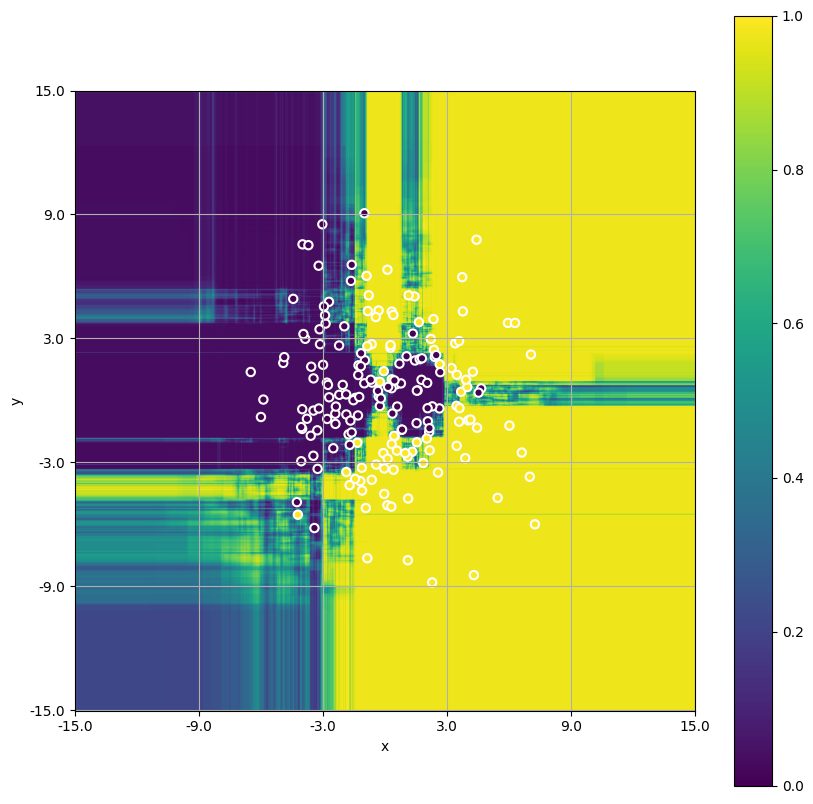

------------------------------------
current loss =  0.6931471805599452
Сейчас обучается модель:  1
current loss =  0.4353517796932853
Сейчас обучается модель:  2
current loss =  0.3908028656500952
Сейчас обучается модель:  3
current loss =  0.35840135813823254
Сейчас обучается модель:  4
current loss =  0.3330222227849766
Сейчас обучается модель:  5
current loss =  0.314541379467893
Сейчас обучается модель:  6
current loss =  0.29889335663786176
Сейчас обучается модель:  7
current loss =  0.288929716186166
Сейчас обучается модель:  8
current loss =  0.28239095790988855
Сейчас обучается модель:  9
current loss =  0.2791852809675807
Сейчас обучается модель:  10
current loss =  0.27714785355917926
Сейчас обучается модель:  11
current loss =  0.2784671951824883
Сейчас обучается модель:  12
current loss =  0.2812977933628898
Сейчас обучается модель:  13
current loss =  0.2844458990725115
Сейчас обучается модель:  14
current loss =  0.28841183846706975
Сейчас обучается модель:  15
current l

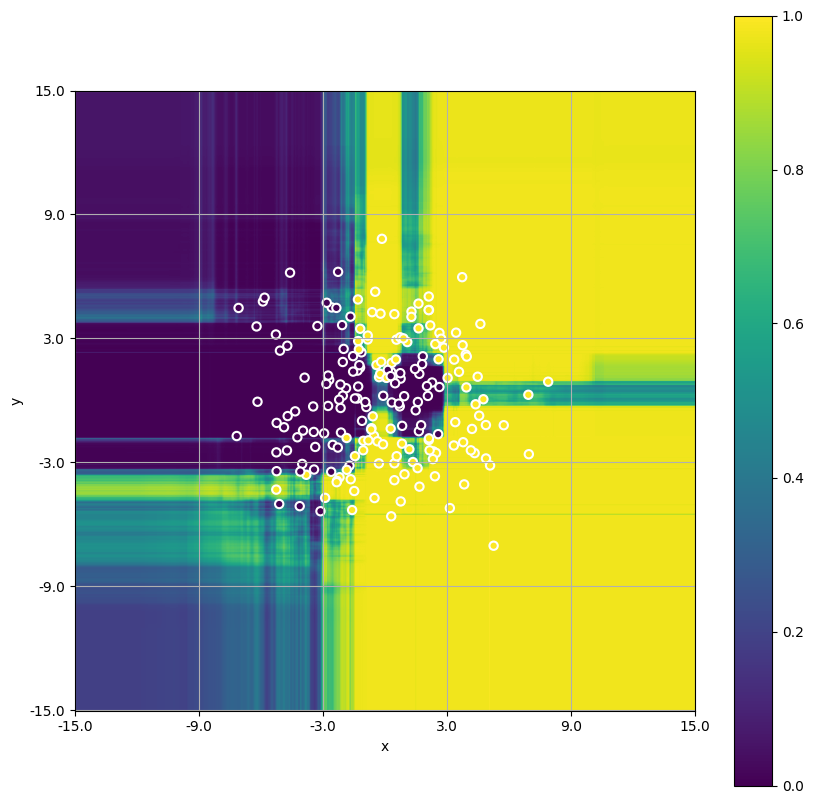

------------------------------------
current loss =  0.6931471805599452
Сейчас обучается модель:  1
current loss =  0.5116440555920856
Сейчас обучается модель:  2
current loss =  0.4775587146276592
Сейчас обучается модель:  3
current loss =  0.4510860540548838
Сейчас обучается модель:  4
current loss =  0.42873084623017105
Сейчас обучается модель:  5
current loss =  0.4112530855845369
Сейчас обучается модель:  6
current loss =  0.39532240077385583
Сейчас обучается модель:  7
current loss =  0.38405100350730687
Сейчас обучается модель:  8
current loss =  0.37723500436016866
Сейчас обучается модель:  9
current loss =  0.3710109409643625
Сейчас обучается модель:  10
current loss =  0.3672684914077533
Сейчас обучается модель:  11
current loss =  0.36524161204150263
Сейчас обучается модель:  12
current loss =  0.3638575311738966
Сейчас обучается модель:  13
current loss =  0.3635283283788702
Сейчас обучается модель:  14
current loss =  0.3644036526476807
Сейчас обучается модель:  15
current

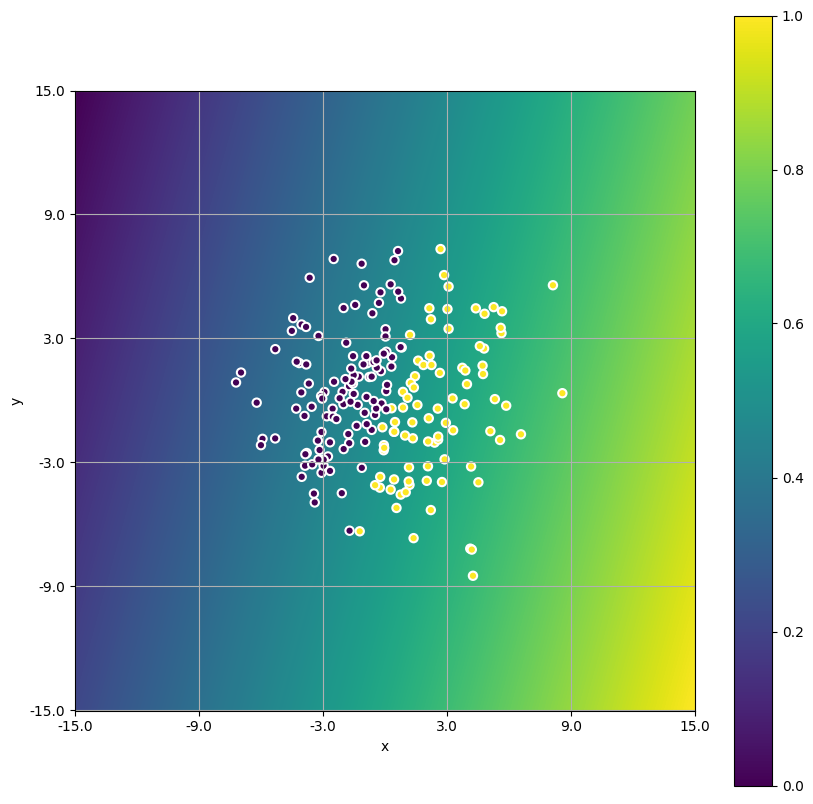

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

i = 0
for base_model in [DecisionTreeRegressor, RandomForestRegressor, LinearRegression]:
    boosting_params = {'n_estimators': 100, 'learning_rate': 0.05,} #'n_iter_early_stopping': 10, 'use_best_model': True}
    base_model_params ={}
    if base_model is (DecisionTreeRegressor, DecisionTreeClassifier):
        base_model_params['max_depth'] = 6
    elif base_model is RandomForestRegressor:
        base_model_params['max_depth'] = 10
        base_model_params['n_estimators'] = 30
    if i < 3:
        variable_models(base_estimator=base_model,
                        base_params=base_model_params,
                        X_train=df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values,
                        X_test=df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values,
                        y_train=df_train.y.values,
                        y_test=df_test.y.values,
                        eval_set=(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values,
                                  df_test.y.values),
                        **boosting_params)

        variable_models(base_model,
                        base_model_params,
                        X_train_synthetic,
                        X_test_synthetic,
                        y_train_synthetic,
                        y_test_synthetic,
                        (X_test_synthetic, y_test_synthetic),
                        True,
                        **boosting_params)

In [ ]:
log_reg_df = LogisticRegression()

log_reg_df.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values,
            df_train.y.values)
df_pred = log_reg_df.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)

print("\nAccuracy on df_test data = ", accuracy_score(df_test.y.values, df_pred), '\n')

log_reg_synth = LogisticRegression()

log_reg_synth.fit(X_train_synthetic, y_train_synthetic)

synth_pred = log_reg_synth.predict(X_test_synthetic)

print("\nAccuracy on synthetic data = ", accuracy_score(y_test_synthetic, synth_pred), '\n')



Accuracy on df_test data =  0.8464439655172413 


Accuracy on synthetic data =  0.68905 



________________________________________________________________________________________________________
***Выводы***: \
1. Лучше всего показал себя Random Forest на обоих тестовых датасетах. Это связано с тем, что у нас большой ансамбль хорошо предсказывающих деревьев, построенных на Random Forest. Каждая модель Random Forest сама по себе хорошо предсказывает данные. Из - за того что мы брали не самые глубокие решающие деревья и обрезали модель, когда ошибка начала увеличиваться, мы избежали переобучения и получили хорошую модель бустинга на лесе.
2. Для того чтобы понять, какая модель быстрее переобучается, необходимо измерить лосс на лучшей итерации и на последней итерации алгоритма, взять разность двух лоссов и сравнить с такими же разностями лоссов других алгоритмов


*   Лоссы Decission tree на обоих датасетах:
    1. 0.27 - 0.23 = 0.04
    2. 0.36 - 0.31 = 0.05 \
  **Тогда средний лосс на Decission tree равен: 0.045** \

*   Лоссы для Random Forest на обоих датасетах:
    1. 0.32 - 0.27 = 0.05
    2. 0.22 - 0.19 = 0.03
  **Тогда средний лосс на Random Forest равен: 0.04** \

*   Лоссы для Linear Regression на обоих датасетах:  
    1. 0.39 - 0.36 = 0.03
    2. 0.58 - 0.53 = 0.05
  **Тогда средний лосс на Linear Regression равен: 0.04** \

  ***Если подумать***, то можно понять, что если взять 2 алгоритма Decission tree и Random Forest одинаковой глубины, то Decission tree будет быстрее переобучаться, потому что там будут разные деревья, тогда как в бустинге на Random Forest будут оптимальные композиции деревьев.

  ***Что касается обрезания бустинга***, то обрезание помогает улучшить качество модели засчет остановки в момент начала переобучения. В данном случае обрезание ничего не поменяло (я проделывал множество экспериментов). Чтобы обрезание имело сильный эффект, необходимо большое количество итераций бустинга. На 100 итерациях обрезание не имеет сильного эффекта. Также обрезание необходимо при большом eta

3. Бустинг над линейными регрессиями и единичная логистическая регрессия имеют примерно одинаковый скор на тестовых данных. Это связано с тем, что неважно, имеем мы бутинг или не имеем, мы все равно строим разделяющую поверхность в виде гиперплоскости. У нас нет такой гибкости как с деревьями. Поэтому и результаты получились одинаковыми.

4. На построенных графиках видно, что обе древовидные структуры имеют примерно одинаковое разбиение. Линейная регрессия же напротив, имеет линию в виде разделяющей поверхности. \
________________________________________________________________________________________________________


#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка?

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:


#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
!pip install optuna
#!pip install xgboost
!pip install catboost
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
def compare_best_models(boosting_model, X_train, X_test, y_train, y_test, synthetic = False, **boosting_params):
    model = boosting_model(**boosting_params)
    model.fit(X_train, y_train)
    pred = np.round(model.predict(X_test) > 0.5)
    print('\nCurrent base estimator: ', boosting_model, '\nboosting params: ', boosting_params)
    if synthetic:
        print("\nAccuracy on synthetic data = ", accuracy_score((y_test == 1), np.round(pred)), '\n')
        plot_predicts(model, X_test, pred, mode='regression')
    else:
        print("\nAccuracy on df_test data = ", accuracy_score((y_test == 1), np.round(pred)), '\n')
    return model

In [115]:
import optuna
from catboost import Pool, CatBoostClassifier

def objective(trial):
    train_pool = Pool(X_train_synthetic, y_train_synthetic)

    test_pool = Pool(X_test_synthetic, y_test_synthetic,)
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 0.71, step=0.05)
    param['depth'] = trial.suggest_int('depth', 4, 8)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['iterations'] = 200
    param['use_best_model'] = True
    param['random_state'] = 228
    param["boosting_type"] = trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])
    param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

    clf = CatBoostClassifier(**param)
    clf.fit(train_pool, eval_set = test_pool)
    clf_pred = clf.predict(X_test_synthetic)
    pred_labels = np.rint(clf_pred)
    accuracy = accuracy_score(y_test_synthetic, pred_labels)
    return accuracy

def optuna_fit():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial

In [ ]:
best_catboost_trial = optuna_fit()

[I 2024-02-02 11:08:00,771] A new study created in memory with name: no-name-3ec8fc3b-42b9-4994-9372-cb6ac747c735


0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 67.4ms	remaining: 13.4s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 141ms	remaining: 14s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 211ms	remaining: 13.8s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 280ms	remaining: 13.7s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 353ms	remaining: 13.8s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 420ms	remaining: 13.6s
6:	learn: 0.2172424	test: 0.2115893	best: 0.2115893 (6)	total: 506ms	remaining: 14s
7:	learn: 0.2122021	test: 0.2069434	best: 0.2069434 (7)	total: 571ms	remaining: 13.7s
8:	learn: 0.2067378	test: 0.2019552	best: 0.2019552 (8)	total: 638ms	remaining: 13.5s
9:	learn: 0.2037824	test: 0.1986892	best: 0.1986892 (9)	total: 711ms	remaining: 13.5s
10:	learn: 0.2014876	test: 0.1963737	best: 0.1963737 (10)	total: 776ms	remaining: 13.3s
11:	learn: 0.1994517	test: 0.1942298	best: 0.1942298 (1

[I 2024-02-02 11:08:15,370] Trial 0 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9229.


197:	learn: 0.1630034	test: 0.1656629	best: 0.1656256 (194)	total: 14.2s	remaining: 143ms
198:	learn: 0.1629861	test: 0.1656638	best: 0.1656256 (194)	total: 14.2s	remaining: 71.4ms
199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 14.3s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.4205701	test: 0.4171883	best: 0.4171883 (0)	total: 59.4ms	remaining: 11.8s
1:	learn: 0.3637565	test: 0.3611603	best: 0.3611603 (1)	total: 118ms	remaining: 11.7s
2:	learn: 0.3151575	test: 0.3111068	best: 0.3111068 (2)	total: 180ms	remaining: 11.8s
3:	learn: 0.2890961	test: 0.2845601	best: 0.2845601 (3)	total: 239ms	remaining: 11.7s
4:	learn: 0.2733167	test: 0.2687137	best: 0.2687137 (4)	total: 296ms	remaining: 11.6s
5:	learn: 0.2602160	test: 0.2550417	best: 0.2550417 (5)	total: 355ms	remaining: 11.5s
6:	learn: 0.2505152	test: 0.2454689	best: 0.2454689 (6)	total: 428ms	remaining: 11.8s
7:	learn: 0.2429281	test: 0.2389883	best: 0.

[I 2024-02-02 11:08:27,994] Trial 1 finished with value: 0.92275 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 4, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9229.


197:	learn: 0.1670202	test: 0.1674236	best: 0.1674160 (196)	total: 12.2s	remaining: 123ms
198:	learn: 0.1669897	test: 0.1673786	best: 0.1673786 (198)	total: 12.3s	remaining: 61.7ms
199:	learn: 0.1669357	test: 0.1673761	best: 0.1673761 (199)	total: 12.3s	remaining: 0us

bestTest = 0.1673761287
bestIteration = 199

0:	learn: 0.5283632	test: 0.5263946	best: 0.5263946 (0)	total: 17.8ms	remaining: 3.53s
1:	learn: 0.4371205	test: 0.4341629	best: 0.4341629 (1)	total: 36.2ms	remaining: 3.58s
2:	learn: 0.3771144	test: 0.3740218	best: 0.3740218 (2)	total: 54.7ms	remaining: 3.59s
3:	learn: 0.3398212	test: 0.3367383	best: 0.3367383 (3)	total: 73.2ms	remaining: 3.59s
4:	learn: 0.3160572	test: 0.3128387	best: 0.3128387 (4)	total: 91.9ms	remaining: 3.58s
5:	learn: 0.2975099	test: 0.2942719	best: 0.2942719 (5)	total: 115ms	remaining: 3.73s
6:	learn: 0.2818244	test: 0.2784648	best: 0.2784648 (6)	total: 134ms	remaining: 3.68s
7:	learn: 0.2708545	test: 0.2674006	best: 0.2674006 (7)	total: 152ms	remaining

[I 2024-02-02 11:08:32,246] Trial 2 finished with value: 0.9219 and parameters: {'learning_rate': 0.11, 'depth': 7, 'min_child_samples': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9229.


0:	learn: 0.4262431	test: 0.4230880	best: 0.4230880 (0)	total: 91.1ms	remaining: 18.1s
1:	learn: 0.3239984	test: 0.3205099	best: 0.3205099 (1)	total: 198ms	remaining: 19.6s
2:	learn: 0.2775292	test: 0.2748368	best: 0.2748368 (2)	total: 300ms	remaining: 19.7s
3:	learn: 0.2554412	test: 0.2522620	best: 0.2522620 (3)	total: 402ms	remaining: 19.7s
4:	learn: 0.2378922	test: 0.2353131	best: 0.2353131 (4)	total: 493ms	remaining: 19.2s
5:	learn: 0.2255852	test: 0.2223529	best: 0.2223529 (5)	total: 590ms	remaining: 19.1s
6:	learn: 0.2166493	test: 0.2131965	best: 0.2131965 (6)	total: 687ms	remaining: 18.9s
7:	learn: 0.2118754	test: 0.2083099	best: 0.2083099 (7)	total: 778ms	remaining: 18.7s
8:	learn: 0.2071553	test: 0.2035125	best: 0.2035125 (8)	total: 878ms	remaining: 18.6s
9:	learn: 0.2033583	test: 0.1997113	best: 0.1997113 (9)	total: 973ms	remaining: 18.5s
10:	learn: 0.1992200	test: 0.1955387	best: 0.1955387 (10)	total: 1.07s	remaining: 18.3s
11:	learn: 0.1972105	test: 0.1934572	best: 0.193457

[I 2024-02-02 11:08:49,700] Trial 3 finished with value: 0.92015 and parameters: {'learning_rate': 0.21000000000000002, 'depth': 8, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9229.


198:	learn: 0.1668555	test: 0.1679015	best: 0.1678969 (195)	total: 17.1s	remaining: 85.9ms
199:	learn: 0.1668555	test: 0.1679014	best: 0.1678969 (195)	total: 17.1s	remaining: 0us

bestTest = 0.1678969103
bestIteration = 195

Shrink model to first 196 iterations.
0:	learn: 0.4361379	test: 0.4336907	best: 0.4336907 (0)	total: 61.9ms	remaining: 12.3s
1:	learn: 0.3334796	test: 0.3297509	best: 0.3297509 (1)	total: 124ms	remaining: 12.3s
2:	learn: 0.3008009	test: 0.2965631	best: 0.2965631 (2)	total: 188ms	remaining: 12.4s
3:	learn: 0.2780624	test: 0.2739577	best: 0.2739577 (3)	total: 251ms	remaining: 12.3s
4:	learn: 0.2631056	test: 0.2594869	best: 0.2594869 (4)	total: 333ms	remaining: 13s
5:	learn: 0.2511238	test: 0.2472862	best: 0.2472862 (5)	total: 397ms	remaining: 12.8s
6:	learn: 0.2440232	test: 0.2398253	best: 0.2398253 (6)	total: 460ms	remaining: 12.7s
7:	learn: 0.2362296	test: 0.2323518	best: 0.2323518 (7)	total: 526ms	remaining: 12.6s
8:	learn: 0.2298715	test: 0.2260125	best: 0.226012

[I 2024-02-02 11:09:02,867] Trial 4 finished with value: 0.92155 and parameters: {'learning_rate': 0.26, 'depth': 5, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9229.


197:	learn: 0.1693673	test: 0.1686276	best: 0.1686276 (197)	total: 12.8s	remaining: 129ms
198:	learn: 0.1693673	test: 0.1686275	best: 0.1686275 (198)	total: 12.8s	remaining: 64.4ms
199:	learn: 0.1693671	test: 0.1686274	best: 0.1686274 (199)	total: 12.9s	remaining: 0us

bestTest = 0.1686273547
bestIteration = 199

0:	learn: 0.4576552	test: 0.4548020	best: 0.4548020 (0)	total: 17.4ms	remaining: 3.46s
1:	learn: 0.3560275	test: 0.3521495	best: 0.3521495 (1)	total: 34.5ms	remaining: 3.41s
2:	learn: 0.3093583	test: 0.3051502	best: 0.3051502 (2)	total: 51.8ms	remaining: 3.4s
3:	learn: 0.2805458	test: 0.2764563	best: 0.2764563 (3)	total: 69ms	remaining: 3.38s
4:	learn: 0.2633015	test: 0.2594516	best: 0.2594516 (4)	total: 85.4ms	remaining: 3.33s
5:	learn: 0.2499555	test: 0.2457689	best: 0.2457689 (5)	total: 103ms	remaining: 3.33s
6:	learn: 0.2377118	test: 0.2340215	best: 0.2340215 (6)	total: 120ms	remaining: 3.32s
7:	learn: 0.2298794	test: 0.2261951	best: 0.2261951 (7)	total: 136ms	remaining: 3

[I 2024-02-02 11:09:06,770] Trial 5 finished with value: 0.92115 and parameters: {'learning_rate': 0.21000000000000002, 'depth': 6, 'min_child_samples': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9229.


198:	learn: 0.1640315	test: 0.1669183	best: 0.1669183 (198)	total: 3.61s	remaining: 18.1ms
199:	learn: 0.1639868	test: 0.1669652	best: 0.1669183 (198)	total: 3.62s	remaining: 0us

bestTest = 0.1669183219
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.3669857	test: 0.3636118	best: 0.3636118 (0)	total: 61.2ms	remaining: 12.2s
1:	learn: 0.3039411	test: 0.2997477	best: 0.2997477 (1)	total: 121ms	remaining: 11.9s
2:	learn: 0.2680989	test: 0.2618658	best: 0.2618658 (2)	total: 181ms	remaining: 11.9s
3:	learn: 0.2538176	test: 0.2490375	best: 0.2490375 (3)	total: 242ms	remaining: 11.9s
4:	learn: 0.2411554	test: 0.2353555	best: 0.2353555 (4)	total: 307ms	remaining: 12s
5:	learn: 0.2294168	test: 0.2236613	best: 0.2236613 (5)	total: 368ms	remaining: 11.9s
6:	learn: 0.2233350	test: 0.2170158	best: 0.2170158 (6)	total: 427ms	remaining: 11.8s
7:	learn: 0.2162151	test: 0.2101366	best: 0.2101366 (7)	total: 488ms	remaining: 11.7s
8:	learn: 0.2109165	test: 0.2047932	best: 0.204793

[I 2024-02-02 11:09:19,276] Trial 6 finished with value: 0.9226 and parameters: {'learning_rate': 0.56, 'depth': 4, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9229.


196:	learn: 0.1676714	test: 0.1673565	best: 0.1673565 (196)	total: 12s	remaining: 183ms
197:	learn: 0.1676714	test: 0.1673566	best: 0.1673565 (196)	total: 12.1s	remaining: 122ms
198:	learn: 0.1676714	test: 0.1673565	best: 0.1673565 (196)	total: 12.1s	remaining: 60.9ms
199:	learn: 0.1676670	test: 0.1673477	best: 0.1673477 (199)	total: 12.2s	remaining: 0us

bestTest = 0.1673477262
bestIteration = 199

0:	learn: 0.5718599	test: 0.5711652	best: 0.5711652 (0)	total: 67.4ms	remaining: 13.4s
1:	learn: 0.5064735	test: 0.5050688	best: 0.5050688 (1)	total: 131ms	remaining: 12.9s
2:	learn: 0.4434588	test: 0.4413090	best: 0.4413090 (2)	total: 190ms	remaining: 12.5s
3:	learn: 0.4155326	test: 0.4131641	best: 0.4131641 (3)	total: 250ms	remaining: 12.2s
4:	learn: 0.3873215	test: 0.3842441	best: 0.3842441 (4)	total: 315ms	remaining: 12.3s
5:	learn: 0.3655072	test: 0.3620048	best: 0.3620048 (5)	total: 378ms	remaining: 12.2s
6:	learn: 0.3539423	test: 0.3509286	best: 0.3509286 (6)	total: 439ms	remaining: 

[I 2024-02-02 11:09:35,201] Trial 7 finished with value: 0.92175 and parameters: {'learning_rate': 0.11, 'depth': 4, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9229.


199:	learn: 0.1770141	test: 0.1740225	best: 0.1740225 (199)	total: 15.6s	remaining: 0us

bestTest = 0.174022507
bestIteration = 199

0:	learn: 0.3526008	test: 0.3485699	best: 0.3485699 (0)	total: 66.5ms	remaining: 13.2s
1:	learn: 0.2862851	test: 0.2837670	best: 0.2837670 (1)	total: 126ms	remaining: 12.5s
2:	learn: 0.2530612	test: 0.2481577	best: 0.2481577 (2)	total: 187ms	remaining: 12.3s
3:	learn: 0.2379972	test: 0.2326380	best: 0.2326380 (3)	total: 248ms	remaining: 12.2s
4:	learn: 0.2256674	test: 0.2201997	best: 0.2201997 (4)	total: 314ms	remaining: 12.3s
5:	learn: 0.2176487	test: 0.2124594	best: 0.2124594 (5)	total: 376ms	remaining: 12.1s
6:	learn: 0.2101554	test: 0.2048643	best: 0.2048643 (6)	total: 436ms	remaining: 12s
7:	learn: 0.2047480	test: 0.2000420	best: 0.2000420 (7)	total: 496ms	remaining: 11.9s
8:	learn: 0.2022675	test: 0.1978618	best: 0.1978618 (8)	total: 572ms	remaining: 12.1s
9:	learn: 0.1987865	test: 0.1938834	best: 0.1938834 (9)	total: 668ms	remaining: 12.7s
10:	lear

[I 2024-02-02 11:09:47,715] Trial 8 finished with value: 0.9223 and parameters: {'learning_rate': 0.66, 'depth': 4, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9229.


199:	learn: 0.1656716	test: 0.1671644	best: 0.1670583 (189)	total: 12.2s	remaining: 0us

bestTest = 0.1670583367
bestIteration = 189

Shrink model to first 190 iterations.
0:	learn: 0.3901902	test: 0.3864427	best: 0.3864427 (0)	total: 14.1ms	remaining: 2.81s
1:	learn: 0.3265937	test: 0.3206645	best: 0.3206645 (1)	total: 37.7ms	remaining: 3.73s
2:	learn: 0.2914391	test: 0.2866933	best: 0.2866933 (2)	total: 53.1ms	remaining: 3.49s
3:	learn: 0.2731786	test: 0.2672949	best: 0.2672949 (3)	total: 67.6ms	remaining: 3.31s
4:	learn: 0.2534450	test: 0.2464056	best: 0.2464056 (4)	total: 82.3ms	remaining: 3.21s
5:	learn: 0.2395684	test: 0.2334048	best: 0.2334048 (5)	total: 96.8ms	remaining: 3.13s
6:	learn: 0.2314731	test: 0.2252282	best: 0.2252282 (6)	total: 112ms	remaining: 3.08s
7:	learn: 0.2245337	test: 0.2191092	best: 0.2191092 (7)	total: 125ms	remaining: 3s
8:	learn: 0.2209575	test: 0.2147620	best: 0.2147620 (8)	total: 142ms	remaining: 3.02s
9:	learn: 0.2179864	test: 0.2120057	best: 0.2120057

[I 2024-02-02 11:09:52,247] Trial 9 finished with value: 0.9215 and parameters: {'learning_rate': 0.46, 'depth': 4, 'min_child_samples': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9229.


Shrink model to first 181 iterations.
0:	learn: 0.6779950	test: 0.6778505	best: 0.6778505 (0)	total: 19.7ms	remaining: 3.92s
1:	learn: 0.6629898	test: 0.6626726	best: 0.6626726 (1)	total: 35.2ms	remaining: 3.48s
2:	learn: 0.6489364	test: 0.6484398	best: 0.6484398 (2)	total: 49.8ms	remaining: 3.27s
3:	learn: 0.6355602	test: 0.6348427	best: 0.6348427 (3)	total: 64.5ms	remaining: 3.16s
4:	learn: 0.6226754	test: 0.6218538	best: 0.6218538 (4)	total: 79.3ms	remaining: 3.09s
5:	learn: 0.6107324	test: 0.6097722	best: 0.6097722 (5)	total: 93.8ms	remaining: 3.03s
6:	learn: 0.5979371	test: 0.5967914	best: 0.5967914 (6)	total: 108ms	remaining: 2.97s
7:	learn: 0.5860970	test: 0.5848564	best: 0.5848564 (7)	total: 122ms	remaining: 2.93s
8:	learn: 0.5744607	test: 0.5730325	best: 0.5730325 (8)	total: 137ms	remaining: 2.9s
9:	learn: 0.5637712	test: 0.5622253	best: 0.5622253 (9)	total: 151ms	remaining: 2.87s
10:	learn: 0.5525060	test: 0.5508320	best: 0.5508320 (10)	total: 165ms	remaining: 2.84s
11:	learn

[I 2024-02-02 11:09:55,635] Trial 10 finished with value: 0.9152 and parameters: {'learning_rate': 0.01, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9229.


191:	learn: 0.2283625	test: 0.2242635	best: 0.2242635 (191)	total: 2.99s	remaining: 125ms
192:	learn: 0.2280013	test: 0.2239249	best: 0.2239249 (192)	total: 3s	remaining: 109ms
193:	learn: 0.2276697	test: 0.2235904	best: 0.2235904 (193)	total: 3.02s	remaining: 93.4ms
194:	learn: 0.2273318	test: 0.2232441	best: 0.2232441 (194)	total: 3.03s	remaining: 77.8ms
195:	learn: 0.2271204	test: 0.2230417	best: 0.2230417 (195)	total: 3.05s	remaining: 62.2ms
196:	learn: 0.2268173	test: 0.2227471	best: 0.2227471 (196)	total: 3.06s	remaining: 46.6ms
197:	learn: 0.2265966	test: 0.2225206	best: 0.2225206 (197)	total: 3.08s	remaining: 31.1ms
198:	learn: 0.2263536	test: 0.2222780	best: 0.2222780 (198)	total: 3.09s	remaining: 15.5ms
199:	learn: 0.2260987	test: 0.2220263	best: 0.2220263 (199)	total: 3.11s	remaining: 0us

bestTest = 0.2220262923
bestIteration = 199

0:	learn: 0.4065737	test: 0.4030240	best: 0.4030240 (0)	total: 59.4ms	remaining: 11.8s
1:	learn: 0.3188034	test: 0.3152441	best: 0.3152441 (1)	

[I 2024-02-02 11:10:09,084] Trial 11 finished with value: 0.9232 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.1s	remaining: 65.7ms
199:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.1s	remaining: 0us

bestTest = 0.1670917891
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3888729	test: 0.3850525	best: 0.3850525 (0)	total: 60.3ms	remaining: 12s
1:	learn: 0.3047988	test: 0.3000965	best: 0.3000965 (1)	total: 119ms	remaining: 11.8s
2:	learn: 0.2754660	test: 0.2702475	best: 0.2702475 (2)	total: 178ms	remaining: 11.7s
3:	learn: 0.2551917	test: 0.2505499	best: 0.2505499 (3)	total: 237ms	remaining: 11.6s
4:	learn: 0.2381352	test: 0.2337566	best: 0.2337566 (4)	total: 303ms	remaining: 11.8s
5:	learn: 0.2313538	test: 0.2268347	best: 0.2268347 (5)	total: 371ms	remaining: 12s
6:	learn: 0.2247839	test: 0.2204138	best: 0.2204138 (6)	total: 430ms	remaining: 11.9s
7:	learn: 0.2164843	test: 0.2120801	best: 0.2120801 (7)	total: 490ms	remaining: 11.8s
8:	learn: 0.2123783	test: 0.2080555	best: 0.2080555 

[I 2024-02-02 11:10:22,521] Trial 12 finished with value: 0.92275 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1643280	test: 0.1665958	best: 0.1665949 (196)	total: 13s	remaining: 131ms
198:	learn: 0.1642897	test: 0.1665605	best: 0.1665605 (198)	total: 13.1s	remaining: 65.6ms
199:	learn: 0.1642775	test: 0.1665263	best: 0.1665263 (199)	total: 13.1s	remaining: 0us

bestTest = 0.1665262537
bestIteration = 199

0:	learn: 0.3106467	test: 0.3076413	best: 0.3076413 (0)	total: 79ms	remaining: 15.7s
1:	learn: 0.2563537	test: 0.2536508	best: 0.2536508 (1)	total: 152ms	remaining: 15s
2:	learn: 0.2204935	test: 0.2177791	best: 0.2177791 (2)	total: 229ms	remaining: 15s
3:	learn: 0.2104826	test: 0.2076438	best: 0.2076438 (3)	total: 310ms	remaining: 15.2s
4:	learn: 0.2041588	test: 0.2017573	best: 0.2017573 (4)	total: 384ms	remaining: 15s
5:	learn: 0.1982039	test: 0.1956608	best: 0.1956608 (5)	total: 459ms	remaining: 14.8s
6:	learn: 0.1952937	test: 0.1930178	best: 0.1930178 (6)	total: 541ms	remaining: 14.9s
7:	learn: 0.1923439	test: 0.1904434	best: 0.1904434 (7)	total: 614ms	remaining: 14.7s
8:	lea

[I 2024-02-02 11:10:39,281] Trial 13 finished with value: 0.9219 and parameters: {'learning_rate': 0.56, 'depth': 7, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1600412	test: 0.1677381	best: 0.1673196 (168)	total: 16.3s	remaining: 81.8ms
199:	learn: 0.1600025	test: 0.1677745	best: 0.1673196 (168)	total: 16.4s	remaining: 0us

bestTest = 0.1673195892
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 0.4278387	test: 0.4245831	best: 0.4245831 (0)	total: 92.6ms	remaining: 18.4s
1:	learn: 0.3358273	test: 0.3324308	best: 0.3324308 (1)	total: 204ms	remaining: 20.2s
2:	learn: 0.3028387	test: 0.2989853	best: 0.2989853 (2)	total: 328ms	remaining: 21.5s
3:	learn: 0.2755789	test: 0.2719340	best: 0.2719340 (3)	total: 446ms	remaining: 21.9s
4:	learn: 0.2597763	test: 0.2557839	best: 0.2557839 (4)	total: 539ms	remaining: 21s
5:	learn: 0.2477481	test: 0.2439124	best: 0.2439124 (5)	total: 636ms	remaining: 20.6s
6:	learn: 0.2410377	test: 0.2363573	best: 0.2363573 (6)	total: 739ms	remaining: 20.4s
7:	learn: 0.2296421	test: 0.2256380	best: 0.2256380 (7)	total: 874ms	remaining: 21s
8:	learn: 0.2239822	test: 0.2199878	best: 0.2199878 

[I 2024-02-02 11:10:53,629] Trial 14 finished with value: 0.92235 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


0:	learn: 0.3206463	test: 0.3176566	best: 0.3176566 (0)	total: 85.2ms	remaining: 17s
1:	learn: 0.2631012	test: 0.2604527	best: 0.2604527 (1)	total: 164ms	remaining: 16.2s
2:	learn: 0.2246321	test: 0.2218926	best: 0.2218926 (2)	total: 239ms	remaining: 15.7s
3:	learn: 0.2169806	test: 0.2136013	best: 0.2136013 (3)	total: 316ms	remaining: 15.5s
4:	learn: 0.2093528	test: 0.2066893	best: 0.2066893 (4)	total: 392ms	remaining: 15.3s
5:	learn: 0.2052501	test: 0.2027802	best: 0.2027802 (5)	total: 468ms	remaining: 15.1s
6:	learn: 0.1981847	test: 0.1950797	best: 0.1950797 (6)	total: 550ms	remaining: 15.2s
7:	learn: 0.1943471	test: 0.1914484	best: 0.1914484 (7)	total: 627ms	remaining: 15s
8:	learn: 0.1922030	test: 0.1890572	best: 0.1890572 (8)	total: 698ms	remaining: 14.8s
9:	learn: 0.1891869	test: 0.1863210	best: 0.1863210 (9)	total: 777ms	remaining: 14.8s
10:	learn: 0.1872545	test: 0.1847217	best: 0.1847217 (10)	total: 859ms	remaining: 14.8s
11:	learn: 0.1860898	test: 0.1834892	best: 0.1834892 (1

[I 2024-02-02 11:11:10,038] Trial 15 finished with value: 0.92205 and parameters: {'learning_rate': 0.51, 'depth': 7, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1597520	test: 0.1671137	best: 0.1666546 (152)	total: 16s	remaining: 161ms
198:	learn: 0.1597209	test: 0.1670857	best: 0.1666546 (152)	total: 16s	remaining: 80.5ms
199:	learn: 0.1596868	test: 0.1670522	best: 0.1666546 (152)	total: 16.1s	remaining: 0us

bestTest = 0.1666546034
bestIteration = 152

Shrink model to first 153 iterations.
0:	learn: 0.3113814	test: 0.3063916	best: 0.3063916 (0)	total: 70.2ms	remaining: 14s
1:	learn: 0.2639055	test: 0.2617848	best: 0.2617848 (1)	total: 141ms	remaining: 13.9s
2:	learn: 0.2341860	test: 0.2310552	best: 0.2310552 (2)	total: 205ms	remaining: 13.5s
3:	learn: 0.2228442	test: 0.2195089	best: 0.2195089 (3)	total: 276ms	remaining: 13.5s
4:	learn: 0.2137811	test: 0.2095668	best: 0.2095668 (4)	total: 359ms	remaining: 14s
5:	learn: 0.2058381	test: 0.2025830	best: 0.2025830 (5)	total: 427ms	remaining: 13.8s
6:	learn: 0.1995053	test: 0.1965888	best: 0.1965888 (6)	total: 492ms	remaining: 13.6s
7:	learn: 0.1946003	test: 0.1917562	best: 0.1917562 

[I 2024-02-02 11:11:24,562] Trial 16 finished with value: 0.92245 and parameters: {'learning_rate': 0.71, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1605357	test: 0.1673045	best: 0.1670506 (177)	total: 14.1s	remaining: 71ms
199:	learn: 0.1604874	test: 0.1672703	best: 0.1670506 (177)	total: 14.2s	remaining: 0us

bestTest = 0.1670506093
bestIteration = 177

Shrink model to first 178 iterations.
0:	learn: 0.4065737	test: 0.4030240	best: 0.4030240 (0)	total: 60.5ms	remaining: 12s
1:	learn: 0.3188034	test: 0.3152441	best: 0.3152441 (1)	total: 123ms	remaining: 12.2s
2:	learn: 0.2861300	test: 0.2823216	best: 0.2823216 (2)	total: 185ms	remaining: 12.2s
3:	learn: 0.2643074	test: 0.2610135	best: 0.2610135 (3)	total: 249ms	remaining: 12.2s
4:	learn: 0.2479156	test: 0.2446843	best: 0.2446843 (4)	total: 324ms	remaining: 12.6s
5:	learn: 0.2358117	test: 0.2325133	best: 0.2325133 (5)	total: 397ms	remaining: 12.8s
6:	learn: 0.2278924	test: 0.2246584	best: 0.2246584 (6)	total: 458ms	remaining: 12.6s
7:	learn: 0.2236224	test: 0.2201397	best: 0.2201397 (7)	total: 519ms	remaining: 12.4s
8:	learn: 0.2187543	test: 0.2157751	best: 0.2157751 

[I 2024-02-02 11:11:38,189] Trial 17 finished with value: 0.9232 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1650604	test: 0.1671175	best: 0.1670918 (194)	total: 13.2s	remaining: 133ms
198:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.3s	remaining: 66.6ms
199:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.3s	remaining: 0us

bestTest = 0.1670917891
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3603630	test: 0.3563369	best: 0.3563369 (0)	total: 15.6ms	remaining: 3.11s
1:	learn: 0.2926903	test: 0.2873101	best: 0.2873101 (1)	total: 32ms	remaining: 3.17s
2:	learn: 0.2552243	test: 0.2490520	best: 0.2490520 (2)	total: 52ms	remaining: 3.42s
3:	learn: 0.2386161	test: 0.2335931	best: 0.2335931 (3)	total: 69.4ms	remaining: 3.4s
4:	learn: 0.2275617	test: 0.2219524	best: 0.2219524 (4)	total: 86.1ms	remaining: 3.36s
5:	learn: 0.2189903	test: 0.2134293	best: 0.2134293 (5)	total: 101ms	remaining: 3.27s
6:	learn: 0.2134680	test: 0.2081008	best: 0.2081008 (6)	total: 116ms	remaining: 3.2s
7:	learn: 0.2073073	test: 0.2022394	best: 0.20

[I 2024-02-02 11:11:43,037] Trial 18 finished with value: 0.92205 and parameters: {'learning_rate': 0.46, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1606917	test: 0.1673057	best: 0.1671447 (195)	total: 4.46s	remaining: 22.4ms
199:	learn: 0.1606738	test: 0.1673068	best: 0.1671447 (195)	total: 4.5s	remaining: 0us

bestTest = 0.1671446829
bestIteration = 195

Shrink model to first 196 iterations.
0:	learn: 0.4534147	test: 0.4504876	best: 0.4504876 (0)	total: 62.3ms	remaining: 12.4s
1:	learn: 0.3584432	test: 0.3552109	best: 0.3552109 (1)	total: 125ms	remaining: 12.3s
2:	learn: 0.3171381	test: 0.3129385	best: 0.3129385 (2)	total: 187ms	remaining: 12.3s
3:	learn: 0.2892828	test: 0.2852162	best: 0.2852162 (3)	total: 251ms	remaining: 12.3s
4:	learn: 0.2768345	test: 0.2721949	best: 0.2721949 (4)	total: 323ms	remaining: 12.6s
5:	learn: 0.2638454	test: 0.2589947	best: 0.2589947 (5)	total: 383ms	remaining: 12.4s
6:	learn: 0.2528503	test: 0.2485130	best: 0.2485130 (6)	total: 445ms	remaining: 12.3s
7:	learn: 0.2432759	test: 0.2384986	best: 0.2384986 (7)	total: 517ms	remaining: 12.4s
8:	learn: 0.2359900	test: 0.2317615	best: 0.23176

[I 2024-02-02 11:11:56,801] Trial 19 finished with value: 0.92275 and parameters: {'learning_rate': 0.26, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


0:	learn: 0.5654878	test: 0.5639131	best: 0.5639131 (0)	total: 61.2ms	remaining: 12.2s
1:	learn: 0.4849560	test: 0.4828996	best: 0.4828996 (1)	total: 125ms	remaining: 12.4s
2:	learn: 0.4193786	test: 0.4167423	best: 0.4167423 (2)	total: 192ms	remaining: 12.6s
3:	learn: 0.3847136	test: 0.3818239	best: 0.3818239 (3)	total: 274ms	remaining: 13.4s
4:	learn: 0.3558338	test: 0.3526624	best: 0.3526624 (4)	total: 338ms	remaining: 13.2s
5:	learn: 0.3369872	test: 0.3336504	best: 0.3336504 (5)	total: 397ms	remaining: 12.8s
6:	learn: 0.3197596	test: 0.3164368	best: 0.3164368 (6)	total: 459ms	remaining: 12.6s
7:	learn: 0.3060527	test: 0.3023680	best: 0.3023680 (7)	total: 530ms	remaining: 12.7s
8:	learn: 0.2954952	test: 0.2916291	best: 0.2916291 (8)	total: 594ms	remaining: 12.6s
9:	learn: 0.2864723	test: 0.2827331	best: 0.2827331 (9)	total: 656ms	remaining: 12.5s
10:	learn: 0.2788846	test: 0.2749275	best: 0.2749275 (10)	total: 716ms	remaining: 12.3s
11:	learn: 0.2736077	test: 0.2700490	best: 0.270049

[I 2024-02-02 11:12:10,813] Trial 20 finished with value: 0.9211 and parameters: {'learning_rate': 0.11, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 65.8ms	remaining: 13.1s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 132ms	remaining: 13.1s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 200ms	remaining: 13.1s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 268ms	remaining: 13.1s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 338ms	remaining: 13.2s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 402ms	remaining: 13s
6:	learn: 0.2172424	test: 0.2115893	best: 0.2115893 (6)	total: 472ms	remaining: 13s
7:	learn: 0.2122021	test: 0.2069434	best: 0.2069434 (7)	total: 542ms	remaining: 13s
8:	learn: 0.2067378	test: 0.2019552	best: 0.2019552 (8)	total: 608ms	remaining: 12.9s
9:	learn: 0.2037824	test: 0.1986892	best: 0.1986892 (9)	total: 680ms	remaining: 12.9s
10:	learn: 0.2014876	test: 0.1963737	best: 0.1963737 (10)	total: 765ms	remaining: 13.2s
11:	learn: 0.1994517	test: 0.1942298	best: 0.1942298 (11)

[I 2024-02-02 11:12:25,648] Trial 21 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1629861	test: 0.1656638	best: 0.1656256 (194)	total: 14.4s	remaining: 72.5ms
199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 14.5s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3687104	test: 0.3645781	best: 0.3645781 (0)	total: 69.3ms	remaining: 13.8s
1:	learn: 0.2788038	test: 0.2766244	best: 0.2766244 (1)	total: 134ms	remaining: 13.2s
2:	learn: 0.2515769	test: 0.2478867	best: 0.2478867 (2)	total: 199ms	remaining: 13s
3:	learn: 0.2349610	test: 0.2311136	best: 0.2311136 (3)	total: 263ms	remaining: 12.9s
4:	learn: 0.2252286	test: 0.2221048	best: 0.2221048 (4)	total: 338ms	remaining: 13.2s
5:	learn: 0.2152774	test: 0.2115614	best: 0.2115614 (5)	total: 403ms	remaining: 13s
6:	learn: 0.2117666	test: 0.2086551	best: 0.2086551 (6)	total: 482ms	remaining: 13.3s
7:	learn: 0.2077569	test: 0.2043179	best: 0.2043179 (7)	total: 559ms	remaining: 13.4s
8:	learn: 0.2019412	test: 0.1981774	best: 0.1981774 

[I 2024-02-02 11:12:40,278] Trial 22 finished with value: 0.9225 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1625792	test: 0.1657808	best: 0.1656303 (158)	total: 14.2s	remaining: 143ms
198:	learn: 0.1625461	test: 0.1657311	best: 0.1656303 (158)	total: 14.2s	remaining: 71.5ms
199:	learn: 0.1625285	test: 0.1657442	best: 0.1656303 (158)	total: 14.3s	remaining: 0us

bestTest = 0.1656302575
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 0.4278387	test: 0.4245831	best: 0.4245831 (0)	total: 65.2ms	remaining: 13s
1:	learn: 0.3358273	test: 0.3324308	best: 0.3324308 (1)	total: 126ms	remaining: 12.5s
2:	learn: 0.3028387	test: 0.2989853	best: 0.2989853 (2)	total: 188ms	remaining: 12.4s
3:	learn: 0.2755789	test: 0.2719340	best: 0.2719340 (3)	total: 250ms	remaining: 12.2s
4:	learn: 0.2597763	test: 0.2557839	best: 0.2557839 (4)	total: 335ms	remaining: 13s
5:	learn: 0.2477481	test: 0.2439124	best: 0.2439124 (5)	total: 401ms	remaining: 13s
6:	learn: 0.2410377	test: 0.2363573	best: 0.2363573 (6)	total: 460ms	remaining: 12.7s
7:	learn: 0.2296421	test: 0.2256380	best: 0.225638

[I 2024-02-02 11:12:54,119] Trial 23 finished with value: 0.92235 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


0:	learn: 0.3478586	test: 0.3449131	best: 0.3449131 (0)	total: 76.4ms	remaining: 15.2s
1:	learn: 0.2762874	test: 0.2738861	best: 0.2738861 (1)	total: 150ms	remaining: 14.8s
2:	learn: 0.2366104	test: 0.2349570	best: 0.2349570 (2)	total: 226ms	remaining: 14.8s
3:	learn: 0.2225240	test: 0.2203220	best: 0.2203220 (3)	total: 306ms	remaining: 15s
4:	learn: 0.2132564	test: 0.2108760	best: 0.2108760 (4)	total: 381ms	remaining: 14.9s
5:	learn: 0.2072879	test: 0.2049454	best: 0.2049454 (5)	total: 456ms	remaining: 14.7s
6:	learn: 0.2023868	test: 0.2000967	best: 0.2000967 (6)	total: 539ms	remaining: 14.9s
7:	learn: 0.1996417	test: 0.1971162	best: 0.1971162 (7)	total: 613ms	remaining: 14.7s
8:	learn: 0.1960284	test: 0.1935479	best: 0.1935479 (8)	total: 689ms	remaining: 14.6s
9:	learn: 0.1934423	test: 0.1914584	best: 0.1914584 (9)	total: 768ms	remaining: 14.6s
10:	learn: 0.1919866	test: 0.1900819	best: 0.1900819 (10)	total: 843ms	remaining: 14.5s
11:	learn: 0.1899939	test: 0.1883043	best: 0.1883043 

[I 2024-02-02 11:13:11,613] Trial 24 finished with value: 0.9221 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 7, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1612508	test: 0.1666862	best: 0.1665822 (189)	total: 17s	remaining: 172ms
198:	learn: 0.1612455	test: 0.1667021	best: 0.1665822 (189)	total: 17.1s	remaining: 85.8ms
199:	learn: 0.1611994	test: 0.1666955	best: 0.1665822 (189)	total: 17.1s	remaining: 0us

bestTest = 0.1665821624
bestIteration = 189

Shrink model to first 190 iterations.
0:	learn: 0.3935209	test: 0.3901630	best: 0.3901630 (0)	total: 70.6ms	remaining: 14.1s
1:	learn: 0.2995916	test: 0.2953236	best: 0.2953236 (1)	total: 152ms	remaining: 15s
2:	learn: 0.2710163	test: 0.2663523	best: 0.2663523 (2)	total: 222ms	remaining: 14.6s
3:	learn: 0.2519844	test: 0.2483811	best: 0.2483811 (3)	total: 299ms	remaining: 14.7s
4:	learn: 0.2327318	test: 0.2292911	best: 0.2292911 (4)	total: 367ms	remaining: 14.3s
5:	learn: 0.2240225	test: 0.2204705	best: 0.2204705 (5)	total: 436ms	remaining: 14.1s
6:	learn: 0.2181843	test: 0.2145117	best: 0.2145117 (6)	total: 513ms	remaining: 14.1s
7:	learn: 0.2123418	test: 0.2088109	best: 0.2088

[I 2024-02-02 11:13:26,600] Trial 25 finished with value: 0.9219 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 6, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1661837	test: 0.1677463	best: 0.1677463 (197)	total: 14.5s	remaining: 147ms
198:	learn: 0.1660499	test: 0.1676775	best: 0.1676775 (198)	total: 14.6s	remaining: 73.4ms
199:	learn: 0.1660461	test: 0.1676811	best: 0.1676775 (198)	total: 14.7s	remaining: 0us

bestTest = 0.1676775372
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.3111353	test: 0.3064121	best: 0.3064121 (0)	total: 21.6ms	remaining: 4.3s
1:	learn: 0.2441040	test: 0.2393018	best: 0.2393018 (1)	total: 41.1ms	remaining: 4.07s
2:	learn: 0.2237000	test: 0.2188925	best: 0.2188925 (2)	total: 60ms	remaining: 3.94s
3:	learn: 0.2072227	test: 0.2031347	best: 0.2031347 (3)	total: 81.1ms	remaining: 3.97s
4:	learn: 0.2013093	test: 0.1969190	best: 0.1969190 (4)	total: 98.2ms	remaining: 3.83s
5:	learn: 0.1950318	test: 0.1911603	best: 0.1911603 (5)	total: 119ms	remaining: 3.83s
6:	learn: 0.1903237	test: 0.1870056	best: 0.1870056 (6)	total: 136ms	remaining: 3.76s
7:	learn: 0.1883776	test: 0.1853837	best: 0

[I 2024-02-02 11:13:31,013] Trial 26 finished with value: 0.9211 and parameters: {'learning_rate': 0.51, 'depth': 8, 'min_child_samples': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


199:	learn: 0.1491477	test: 0.1714183	best: 0.1685600 (49)	total: 4.11s	remaining: 0us

bestTest = 0.1685600461
bestIteration = 49

Shrink model to first 50 iterations.
0:	learn: 0.4534147	test: 0.4504876	best: 0.4504876 (0)	total: 63.1ms	remaining: 12.6s
1:	learn: 0.3584432	test: 0.3552109	best: 0.3552109 (1)	total: 129ms	remaining: 12.7s
2:	learn: 0.3171381	test: 0.3129385	best: 0.3129385 (2)	total: 191ms	remaining: 12.6s
3:	learn: 0.2892828	test: 0.2852162	best: 0.2852162 (3)	total: 253ms	remaining: 12.4s
4:	learn: 0.2768345	test: 0.2721949	best: 0.2721949 (4)	total: 325ms	remaining: 12.7s
5:	learn: 0.2638454	test: 0.2589947	best: 0.2589947 (5)	total: 387ms	remaining: 12.5s
6:	learn: 0.2528503	test: 0.2485130	best: 0.2485130 (6)	total: 461ms	remaining: 12.7s
7:	learn: 0.2432759	test: 0.2384986	best: 0.2384986 (7)	total: 522ms	remaining: 12.5s
8:	learn: 0.2359900	test: 0.2317615	best: 0.2317615 (8)	total: 598ms	remaining: 12.7s
9:	learn: 0.2295262	test: 0.2256486	best: 0.2256486 (9)	

[I 2024-02-02 11:13:44,976] Trial 27 finished with value: 0.92275 and parameters: {'learning_rate': 0.26, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1665585	test: 0.1667204	best: 0.1667125 (194)	total: 13.6s	remaining: 68.2ms
199:	learn: 0.1665284	test: 0.1667106	best: 0.1667106 (199)	total: 13.6s	remaining: 0us

bestTest = 0.1667105772
bestIteration = 199

0:	learn: 0.5211954	test: 0.5190893	best: 0.5190893 (0)	total: 64.1ms	remaining: 12.7s
1:	learn: 0.4351774	test: 0.4331583	best: 0.4331583 (1)	total: 128ms	remaining: 12.7s
2:	learn: 0.3705951	test: 0.3675144	best: 0.3675144 (2)	total: 190ms	remaining: 12.5s
3:	learn: 0.3378059	test: 0.3341404	best: 0.3341404 (3)	total: 252ms	remaining: 12.3s
4:	learn: 0.3167935	test: 0.3133299	best: 0.3133299 (4)	total: 324ms	remaining: 12.7s
5:	learn: 0.2960348	test: 0.2923247	best: 0.2923247 (5)	total: 388ms	remaining: 12.5s
6:	learn: 0.2822937	test: 0.2790227	best: 0.2790227 (6)	total: 466ms	remaining: 12.8s
7:	learn: 0.2718394	test: 0.2683114	best: 0.2683114 (7)	total: 570ms	remaining: 13.7s
8:	learn: 0.2644663	test: 0.2609333	best: 0.2609333 (8)	total: 685ms	remaining: 14.5s


[I 2024-02-02 11:13:59,448] Trial 28 finished with value: 0.9213 and parameters: {'learning_rate': 0.16000000000000003, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


198:	learn: 0.1695571	test: 0.1691582	best: 0.1691582 (198)	total: 14s	remaining: 70.4ms
199:	learn: 0.1694755	test: 0.1690714	best: 0.1690714 (199)	total: 14.1s	remaining: 0us

bestTest = 0.1690714406
bestIteration = 199

0:	learn: 0.3687104	test: 0.3645781	best: 0.3645781 (0)	total: 114ms	remaining: 22.7s
1:	learn: 0.2788038	test: 0.2766244	best: 0.2766244 (1)	total: 207ms	remaining: 20.5s
2:	learn: 0.2515769	test: 0.2478867	best: 0.2478867 (2)	total: 309ms	remaining: 20.3s
3:	learn: 0.2349610	test: 0.2311136	best: 0.2311136 (3)	total: 441ms	remaining: 21.6s
4:	learn: 0.2252286	test: 0.2221048	best: 0.2221048 (4)	total: 553ms	remaining: 21.6s
5:	learn: 0.2152774	test: 0.2115614	best: 0.2115614 (5)	total: 682ms	remaining: 22s
6:	learn: 0.2117666	test: 0.2086551	best: 0.2086551 (6)	total: 817ms	remaining: 22.5s
7:	learn: 0.2077569	test: 0.2043179	best: 0.2043179 (7)	total: 942ms	remaining: 22.6s
8:	learn: 0.2019412	test: 0.1981774	best: 0.1981774 (8)	total: 1.01s	remaining: 21.4s
9:	le

[I 2024-02-02 11:14:14,819] Trial 29 finished with value: 0.9225 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 6, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


199:	learn: 0.1625285	test: 0.1657442	best: 0.1656303 (158)	total: 14.9s	remaining: 0us

bestTest = 0.1656302575
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 0.4194372	test: 0.4173151	best: 0.4173151 (0)	total: 61.3ms	remaining: 12.2s
1:	learn: 0.3486182	test: 0.3444541	best: 0.3444541 (1)	total: 122ms	remaining: 12.1s
2:	learn: 0.3118216	test: 0.3079134	best: 0.3079134 (2)	total: 182ms	remaining: 11.9s
3:	learn: 0.2874064	test: 0.2837696	best: 0.2837696 (3)	total: 253ms	remaining: 12.4s
4:	learn: 0.2742660	test: 0.2697976	best: 0.2697976 (4)	total: 331ms	remaining: 12.9s
5:	learn: 0.2573811	test: 0.2522273	best: 0.2522273 (5)	total: 392ms	remaining: 12.7s
6:	learn: 0.2484078	test: 0.2440500	best: 0.2440500 (6)	total: 452ms	remaining: 12.5s
7:	learn: 0.2395918	test: 0.2349751	best: 0.2349751 (7)	total: 522ms	remaining: 12.5s
8:	learn: 0.2336313	test: 0.2296264	best: 0.2296264 (8)	total: 594ms	remaining: 12.6s
9:	learn: 0.2290042	test: 0.2246511	best: 0.2246511 (

[I 2024-02-02 11:14:27,958] Trial 30 finished with value: 0.92125 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 4, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9232.


196:	learn: 0.1688546	test: 0.1684729	best: 0.1684729 (196)	total: 12.7s	remaining: 193ms
197:	learn: 0.1688418	test: 0.1684717	best: 0.1684717 (197)	total: 12.7s	remaining: 128ms
198:	learn: 0.1688336	test: 0.1684433	best: 0.1684433 (198)	total: 12.8s	remaining: 64.1ms
199:	learn: 0.1688314	test: 0.1684467	best: 0.1684433 (198)	total: 12.8s	remaining: 0us

bestTest = 0.1684432643
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 64.7ms	remaining: 12.9s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 130ms	remaining: 12.9s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 196ms	remaining: 12.9s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 262ms	remaining: 12.8s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 340ms	remaining: 13.3s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 404ms	remaining: 13.1s
6:	learn: 0.2172424	test: 0.2115893	best

[I 2024-02-02 11:14:42,895] Trial 31 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 14.6s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3662078	test: 0.3633090	best: 0.3633090 (0)	total: 75ms	remaining: 14.9s
1:	learn: 0.2899173	test: 0.2871780	best: 0.2871780 (1)	total: 150ms	remaining: 14.9s
2:	learn: 0.2543609	test: 0.2514496	best: 0.2514496 (2)	total: 236ms	remaining: 15.5s
3:	learn: 0.2376214	test: 0.2338603	best: 0.2338603 (3)	total: 330ms	remaining: 16.2s
4:	learn: 0.2229866	test: 0.2187907	best: 0.2187907 (4)	total: 408ms	remaining: 15.9s
5:	learn: 0.2124371	test: 0.2091122	best: 0.2091122 (5)	total: 486ms	remaining: 15.7s
6:	learn: 0.2070161	test: 0.2035069	best: 0.2035069 (6)	total: 578ms	remaining: 15.9s
7:	learn: 0.2040629	test: 0.2006091	best: 0.2006091 (7)	total: 655ms	remaining: 15.7s
8:	learn: 0.1994451	test: 0.1962109	best: 0.1962109 (8)	total: 730ms	remaining: 15.5s
9:	learn: 0.1967006	test: 0.1936961	best: 0.1936961 (9)

[I 2024-02-02 11:14:59,769] Trial 32 finished with value: 0.9222 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 7, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


197:	learn: 0.1612591	test: 0.1668712	best: 0.1667162 (186)	total: 16.4s	remaining: 165ms
198:	learn: 0.1612338	test: 0.1668352	best: 0.1667162 (186)	total: 16.5s	remaining: 82.7ms
199:	learn: 0.1612174	test: 0.1668163	best: 0.1667162 (186)	total: 16.5s	remaining: 0us

bestTest = 0.1667161593
bestIteration = 186

Shrink model to first 187 iterations.
0:	learn: 0.4082623	test: 0.4045454	best: 0.4045454 (0)	total: 66.7ms	remaining: 13.3s
1:	learn: 0.3171666	test: 0.3135756	best: 0.3135756 (1)	total: 138ms	remaining: 13.6s
2:	learn: 0.2769748	test: 0.2726705	best: 0.2726705 (2)	total: 209ms	remaining: 13.7s
3:	learn: 0.2554722	test: 0.2507196	best: 0.2507196 (3)	total: 286ms	remaining: 14s
4:	learn: 0.2425355	test: 0.2374207	best: 0.2374207 (4)	total: 355ms	remaining: 13.8s
5:	learn: 0.2284135	test: 0.2238501	best: 0.2238501 (5)	total: 427ms	remaining: 13.8s
6:	learn: 0.2200072	test: 0.2149593	best: 0.2149593 (6)	total: 502ms	remaining: 13.8s
7:	learn: 0.2159313	test: 0.2109874	best: 0.21

[I 2024-02-02 11:15:15,824] Trial 33 finished with value: 0.92155 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 11 with value: 0.9232.


199:	learn: 0.1636462	test: 0.1662243	best: 0.1662243 (199)	total: 15.7s	remaining: 0us

bestTest = 0.1662243182
bestIteration = 199

0:	learn: 0.3539837	test: 0.3496883	best: 0.3496883 (0)	total: 65.6ms	remaining: 13.1s
1:	learn: 0.2698728	test: 0.2676885	best: 0.2676885 (1)	total: 130ms	remaining: 12.8s
2:	learn: 0.2460175	test: 0.2436606	best: 0.2436606 (2)	total: 195ms	remaining: 12.8s
3:	learn: 0.2322237	test: 0.2304996	best: 0.2304996 (3)	total: 262ms	remaining: 12.9s
4:	learn: 0.2192417	test: 0.2168104	best: 0.2168104 (4)	total: 342ms	remaining: 13.4s
5:	learn: 0.2123557	test: 0.2093328	best: 0.2093328 (5)	total: 404ms	remaining: 13.1s
6:	learn: 0.2086650	test: 0.2062988	best: 0.2062988 (6)	total: 468ms	remaining: 12.9s
7:	learn: 0.2041156	test: 0.2013531	best: 0.2013531 (7)	total: 534ms	remaining: 12.8s
8:	learn: 0.2009890	test: 0.1978202	best: 0.1978202 (8)	total: 626ms	remaining: 13.3s
9:	learn: 0.1973026	test: 0.1940954	best: 0.1940954 (9)	total: 691ms	remaining: 13.1s
10:	l

[I 2024-02-02 11:15:30,732] Trial 34 finished with value: 0.92325 and parameters: {'learning_rate': 0.46, 'depth': 6, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1619620	test: 0.1662297	best: 0.1662051 (192)	total: 14.4s	remaining: 146ms
198:	learn: 0.1619612	test: 0.1662316	best: 0.1662051 (192)	total: 14.5s	remaining: 72.8ms
199:	learn: 0.1619336	test: 0.1662437	best: 0.1662051 (192)	total: 14.6s	remaining: 0us

bestTest = 0.1662050944
bestIteration = 192

Shrink model to first 193 iterations.
0:	learn: 0.3263257	test: 0.3221415	best: 0.3221415 (0)	total: 16.2ms	remaining: 3.21s
1:	learn: 0.2519569	test: 0.2477967	best: 0.2477967 (1)	total: 33.7ms	remaining: 3.33s
2:	learn: 0.2283522	test: 0.2233741	best: 0.2233741 (2)	total: 53.2ms	remaining: 3.49s
3:	learn: 0.2178348	test: 0.2131448	best: 0.2131448 (3)	total: 70.2ms	remaining: 3.44s
4:	learn: 0.2071675	test: 0.2033040	best: 0.2033040 (4)	total: 88.1ms	remaining: 3.44s
5:	learn: 0.1993817	test: 0.1952091	best: 0.1952091 (5)	total: 109ms	remaining: 3.54s
6:	learn: 0.1958097	test: 0.1917092	best: 0.1917092 (6)	total: 128ms	remaining: 3.52s
7:	learn: 0.1926801	test: 0.1890886	best

[I 2024-02-02 11:15:34,585] Trial 35 finished with value: 0.92175 and parameters: {'learning_rate': 0.46, 'depth': 7, 'min_child_samples': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


193:	learn: 0.1537426	test: 0.1684682	best: 0.1671421 (100)	total: 3.45s	remaining: 107ms
194:	learn: 0.1536406	test: 0.1685110	best: 0.1671421 (100)	total: 3.46s	remaining: 88.8ms
195:	learn: 0.1536059	test: 0.1685088	best: 0.1671421 (100)	total: 3.48s	remaining: 71ms
196:	learn: 0.1535519	test: 0.1684921	best: 0.1671421 (100)	total: 3.49s	remaining: 53.2ms
197:	learn: 0.1535213	test: 0.1684898	best: 0.1671421 (100)	total: 3.51s	remaining: 35.4ms
198:	learn: 0.1534917	test: 0.1684958	best: 0.1671421 (100)	total: 3.52s	remaining: 17.7ms
199:	learn: 0.1534307	test: 0.1685922	best: 0.1671421 (100)	total: 3.54s	remaining: 0us

bestTest = 0.1671420951
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.3339530	test: 0.3305850	best: 0.3305850 (0)	total: 65ms	remaining: 12.9s
1:	learn: 0.2635596	test: 0.2576666	best: 0.2576666 (1)	total: 130ms	remaining: 12.8s
2:	learn: 0.2429843	test: 0.2381679	best: 0.2381679 (2)	total: 194ms	remaining: 12.8s
3:	learn: 0.2289784	test: 0.

[I 2024-02-02 11:15:47,863] Trial 36 finished with value: 0.9225 and parameters: {'learning_rate': 0.56, 'depth': 5, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1656217	test: 0.1660520	best: 0.1660520 (198)	total: 12.9s	remaining: 64.7ms
199:	learn: 0.1656214	test: 0.1660534	best: 0.1660520 (198)	total: 12.9s	remaining: 0us

bestTest = 0.16605204
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.4669290	test: 0.4638597	best: 0.4638597 (0)	total: 65.8ms	remaining: 13.1s
1:	learn: 0.3688626	test: 0.3655159	best: 0.3655159 (1)	total: 133ms	remaining: 13.2s
2:	learn: 0.3191766	test: 0.3148353	best: 0.3148353 (2)	total: 209ms	remaining: 13.7s
3:	learn: 0.2938001	test: 0.2889519	best: 0.2889519 (3)	total: 283ms	remaining: 13.9s
4:	learn: 0.2672373	test: 0.2628164	best: 0.2628164 (4)	total: 352ms	remaining: 13.7s
5:	learn: 0.2552164	test: 0.2512825	best: 0.2512825 (5)	total: 421ms	remaining: 13.6s
6:	learn: 0.2448311	test: 0.2405373	best: 0.2405373 (6)	total: 491ms	remaining: 13.5s
7:	learn: 0.2341872	test: 0.2298995	best: 0.2298995 (7)	total: 562ms	remaining: 13.5s
8:	learn: 0.2289452	test: 0.2245762	best: 0.224576

[I 2024-02-02 11:16:02,997] Trial 37 finished with value: 0.92185 and parameters: {'learning_rate': 0.21000000000000002, 'depth': 6, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1656539	test: 0.1668645	best: 0.1668293 (193)	total: 14.7s	remaining: 74ms
199:	learn: 0.1656170	test: 0.1668374	best: 0.1668293 (193)	total: 14.8s	remaining: 0us

bestTest = 0.1668293073
bestIteration = 193

Shrink model to first 194 iterations.
0:	learn: 0.3590540	test: 0.3553532	best: 0.3553532 (0)	total: 62.5ms	remaining: 12.4s
1:	learn: 0.2931239	test: 0.2902592	best: 0.2902592 (1)	total: 133ms	remaining: 13.2s
2:	learn: 0.2597663	test: 0.2540637	best: 0.2540637 (2)	total: 201ms	remaining: 13.2s
3:	learn: 0.2465237	test: 0.2419636	best: 0.2419636 (3)	total: 285ms	remaining: 14s
4:	learn: 0.2306740	test: 0.2249490	best: 0.2249490 (4)	total: 382ms	remaining: 14.9s
5:	learn: 0.2225453	test: 0.2168035	best: 0.2168035 (5)	total: 508ms	remaining: 16.4s
6:	learn: 0.2156089	test: 0.2100328	best: 0.2100328 (6)	total: 625ms	remaining: 17.2s
7:	learn: 0.2118583	test: 0.2069132	best: 0.2069132 (7)	total: 742ms	remaining: 17.8s
8:	learn: 0.2083599	test: 0.2030030	best: 0.2030030 

[I 2024-02-02 11:16:15,948] Trial 38 finished with value: 0.9225 and parameters: {'learning_rate': 0.6100000000000001, 'depth': 4, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3484868	test: 0.3441718	best: 0.3441718 (0)	total: 35ms	remaining: 6.96s
1:	learn: 0.2786612	test: 0.2721790	best: 0.2721790 (1)	total: 74.1ms	remaining: 7.34s
2:	learn: 0.2520480	test: 0.2449424	best: 0.2449424 (2)	total: 116ms	remaining: 7.6s
3:	learn: 0.2333116	test: 0.2273543	best: 0.2273543 (3)	total: 155ms	remaining: 7.61s
4:	learn: 0.2227987	test: 0.2166965	best: 0.2166965 (4)	total: 201ms	remaining: 7.83s
5:	learn: 0.2170648	test: 0.2120726	best: 0.2120726 (5)	total: 248ms	remaining: 8.02s
6:	learn: 0.2116453	test: 0.2058774	best: 0.2058774 (6)	total: 288ms	remaining: 7.94s
7:	learn: 0.2066604	test: 0.2015662	best: 0.2015662 (7)	total: 329ms	remaining: 7.89s
8:	learn: 0.2033874	test: 0.1985329	best: 0.1985329 (8)	total: 367ms	remaining: 7.79s
9:	learn: 0.1995416	test: 0.1950406	best: 0.1950406 (9)	total: 407ms	remaining: 7.73s
10:	learn: 0.1972004	test: 0.1930828	best: 0.1930828 (10)	total: 451ms	remaining: 7.75s
11:	learn: 0.1954263	test: 0.1914130	best: 0.1914130 

[I 2024-02-02 11:16:20,910] Trial 39 finished with value: 0.9219 and parameters: {'learning_rate': 0.51, 'depth': 5, 'min_child_samples': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3208836	test: 0.3190013	best: 0.3190013 (0)	total: 88ms	remaining: 17.5s
1:	learn: 0.2625271	test: 0.2609849	best: 0.2609849 (1)	total: 180ms	remaining: 17.8s
2:	learn: 0.2278125	test: 0.2258352	best: 0.2258352 (2)	total: 272ms	remaining: 17.8s
3:	learn: 0.2165101	test: 0.2142961	best: 0.2142961 (3)	total: 373ms	remaining: 18.3s
4:	learn: 0.2091885	test: 0.2067510	best: 0.2067510 (4)	total: 468ms	remaining: 18.2s
5:	learn: 0.2030598	test: 0.2001850	best: 0.2001850 (5)	total: 556ms	remaining: 18s
6:	learn: 0.1973255	test: 0.1944358	best: 0.1944358 (6)	total: 660ms	remaining: 18.2s
7:	learn: 0.1949024	test: 0.1922025	best: 0.1922025 (7)	total: 751ms	remaining: 18s
8:	learn: 0.1924181	test: 0.1901574	best: 0.1901574 (8)	total: 842ms	remaining: 17.9s
9:	learn: 0.1897766	test: 0.1877378	best: 0.1877378 (9)	total: 960ms	remaining: 18.2s
10:	learn: 0.1883566	test: 0.1864434	best: 0.1864434 (10)	total: 1.05s	remaining: 18s
11:	learn: 0.1869044	test: 0.1849481	best: 0.1849481 (11)	t

[I 2024-02-02 11:16:40,928] Trial 40 finished with value: 0.9227 and parameters: {'learning_rate': 0.46, 'depth': 8, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1587103	test: 0.1678475	best: 0.1665657 (97)	total: 19.6s	remaining: 0us

bestTest = 0.1665657307
bestIteration = 97

Shrink model to first 98 iterations.
0:	learn: 0.3687104	test: 0.3645781	best: 0.3645781 (0)	total: 120ms	remaining: 23.9s
1:	learn: 0.2788038	test: 0.2766244	best: 0.2766244 (1)	total: 246ms	remaining: 24.4s
2:	learn: 0.2515769	test: 0.2478867	best: 0.2478867 (2)	total: 364ms	remaining: 23.9s
3:	learn: 0.2349610	test: 0.2311136	best: 0.2311136 (3)	total: 486ms	remaining: 23.8s
4:	learn: 0.2252286	test: 0.2221048	best: 0.2221048 (4)	total: 615ms	remaining: 24s
5:	learn: 0.2152774	test: 0.2115614	best: 0.2115614 (5)	total: 746ms	remaining: 24.1s
6:	learn: 0.2117666	test: 0.2086551	best: 0.2086551 (6)	total: 875ms	remaining: 24.1s
7:	learn: 0.2077569	test: 0.2043179	best: 0.2043179 (7)	total: 979ms	remaining: 23.5s
8:	learn: 0.2019412	test: 0.1981774	best: 0.1981774 (8)	total: 1.12s	remaining: 23.8s
9:	learn: 0.2007026	test: 0.1972226	best: 0.1972226 (9)	tot

[I 2024-02-02 11:16:56,754] Trial 41 finished with value: 0.9225 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 6, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1625285	test: 0.1657442	best: 0.1656303 (158)	total: 15.4s	remaining: 0us

bestTest = 0.1656302575
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 0.4082623	test: 0.4045454	best: 0.4045454 (0)	total: 68.6ms	remaining: 13.6s
1:	learn: 0.3171666	test: 0.3135756	best: 0.3135756 (1)	total: 134ms	remaining: 13.3s
2:	learn: 0.2769748	test: 0.2726705	best: 0.2726705 (2)	total: 199ms	remaining: 13.1s
3:	learn: 0.2554722	test: 0.2507196	best: 0.2507196 (3)	total: 264ms	remaining: 12.9s
4:	learn: 0.2425355	test: 0.2374207	best: 0.2374207 (4)	total: 342ms	remaining: 13.4s
5:	learn: 0.2284135	test: 0.2238501	best: 0.2238501 (5)	total: 413ms	remaining: 13.3s
6:	learn: 0.2200072	test: 0.2149593	best: 0.2149593 (6)	total: 478ms	remaining: 13.2s
7:	learn: 0.2159313	test: 0.2109874	best: 0.2109874 (7)	total: 569ms	remaining: 13.7s
8:	learn: 0.2116192	test: 0.2068233	best: 0.2068233 (8)	total: 635ms	remaining: 13.5s
9:	learn: 0.2078853	test: 0.2031559	best: 0.2031559 (

[I 2024-02-02 11:17:11,691] Trial 42 finished with value: 0.92155 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1637081	test: 0.1662307	best: 0.1662307 (197)	total: 14.5s	remaining: 146ms
198:	learn: 0.1636845	test: 0.1662447	best: 0.1662307 (197)	total: 14.5s	remaining: 73ms
199:	learn: 0.1636462	test: 0.1662243	best: 0.1662243 (199)	total: 14.6s	remaining: 0us

bestTest = 0.1662243182
bestIteration = 199

0:	learn: 0.4164507	test: 0.4137695	best: 0.4137695 (0)	total: 74.9ms	remaining: 14.9s
1:	learn: 0.3149621	test: 0.3114793	best: 0.3114793 (1)	total: 155ms	remaining: 15.3s
2:	learn: 0.2752177	test: 0.2711836	best: 0.2711836 (2)	total: 241ms	remaining: 15.9s
3:	learn: 0.2526349	test: 0.2482110	best: 0.2482110 (3)	total: 327ms	remaining: 16s
4:	learn: 0.2321779	test: 0.2281390	best: 0.2281390 (4)	total: 406ms	remaining: 15.8s
5:	learn: 0.2226012	test: 0.2184633	best: 0.2184633 (5)	total: 479ms	remaining: 15.5s
6:	learn: 0.2159774	test: 0.2122393	best: 0.2122393 (6)	total: 561ms	remaining: 15.5s
7:	learn: 0.2119654	test: 0.2077855	best: 0.2077855 (7)	total: 632ms	remaining: 15.2s


[I 2024-02-02 11:17:28,425] Trial 43 finished with value: 0.92285 and parameters: {'learning_rate': 0.26, 'depth': 7, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1631283	test: 0.1661040	best: 0.1660718 (193)	total: 16.3s	remaining: 82.1ms
199:	learn: 0.1631119	test: 0.1660865	best: 0.1660718 (193)	total: 16.4s	remaining: 0us

bestTest = 0.1660717563
bestIteration = 193

Shrink model to first 194 iterations.
0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 64.2ms	remaining: 12.8s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 129ms	remaining: 12.8s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 213ms	remaining: 14s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 290ms	remaining: 14.2s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 358ms	remaining: 13.9s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 431ms	remaining: 13.9s
6:	learn: 0.2172424	test: 0.2115893	best: 0.2115893 (6)	total: 499ms	remaining: 13.8s
7:	learn: 0.2122021	test: 0.2069434	best: 0.2069434 (7)	total: 571ms	remaining: 13.7s
8:	learn: 0.2067378	test: 0.2019552	best: 0.201955

[I 2024-02-02 11:17:43,300] Trial 44 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1629861	test: 0.1656638	best: 0.1656256 (194)	total: 14.5s	remaining: 72.7ms
199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 14.5s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3877351	test: 0.3849025	best: 0.3849025 (0)	total: 81.9ms	remaining: 16.3s
1:	learn: 0.3011206	test: 0.2971542	best: 0.2971542 (1)	total: 192ms	remaining: 19s
2:	learn: 0.2734091	test: 0.2689448	best: 0.2689448 (2)	total: 324ms	remaining: 21.3s
3:	learn: 0.2545698	test: 0.2496120	best: 0.2496120 (3)	total: 415ms	remaining: 20.3s
4:	learn: 0.2438563	test: 0.2378033	best: 0.2378033 (4)	total: 551ms	remaining: 21.5s
5:	learn: 0.2348553	test: 0.2296110	best: 0.2296110 (5)	total: 673ms	remaining: 21.8s
6:	learn: 0.2270181	test: 0.2213219	best: 0.2213219 (6)	total: 802ms	remaining: 22.1s
7:	learn: 0.2212811	test: 0.2161498	best: 0.2161498 (7)	total: 932ms	remaining: 22.4s
8:	learn: 0.2168307	test: 0.2111879	best: 0.211187

[I 2024-02-02 11:17:57,896] Trial 45 finished with value: 0.92245 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1663394	test: 0.1672711	best: 0.1672627 (196)	total: 14s	remaining: 70.5ms
199:	learn: 0.1663394	test: 0.1672711	best: 0.1672627 (196)	total: 14.1s	remaining: 0us

bestTest = 0.1672627489
bestIteration = 196

Shrink model to first 197 iterations.
0:	learn: 0.4669290	test: 0.4638597	best: 0.4638597 (0)	total: 127ms	remaining: 25.2s
1:	learn: 0.3688626	test: 0.3655159	best: 0.3655159 (1)	total: 194ms	remaining: 19.2s
2:	learn: 0.3191766	test: 0.3148353	best: 0.3148353 (2)	total: 263ms	remaining: 17.3s
3:	learn: 0.2938001	test: 0.2889519	best: 0.2889519 (3)	total: 330ms	remaining: 16.2s
4:	learn: 0.2672373	test: 0.2628164	best: 0.2628164 (4)	total: 404ms	remaining: 15.7s
5:	learn: 0.2552164	test: 0.2512825	best: 0.2512825 (5)	total: 469ms	remaining: 15.2s
6:	learn: 0.2448311	test: 0.2405373	best: 0.2405373 (6)	total: 536ms	remaining: 14.8s
7:	learn: 0.2341872	test: 0.2298995	best: 0.2298995 (7)	total: 619ms	remaining: 14.9s
8:	learn: 0.2289452	test: 0.2245762	best: 0.2245762

[I 2024-02-02 11:18:13,357] Trial 46 finished with value: 0.92185 and parameters: {'learning_rate': 0.21000000000000002, 'depth': 6, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3920611	test: 0.3889354	best: 0.3889354 (0)	total: 12.5ms	remaining: 2.49s
1:	learn: 0.3255606	test: 0.3201119	best: 0.3201119 (1)	total: 40.8ms	remaining: 4.04s
2:	learn: 0.2899327	test: 0.2845445	best: 0.2845445 (2)	total: 52.3ms	remaining: 3.44s
3:	learn: 0.2690723	test: 0.2634282	best: 0.2634282 (3)	total: 65ms	remaining: 3.19s
4:	learn: 0.2516370	test: 0.2452208	best: 0.2452208 (4)	total: 78.1ms	remaining: 3.04s
5:	learn: 0.2397914	test: 0.2334616	best: 0.2334616 (5)	total: 92ms	remaining: 2.97s
6:	learn: 0.2340092	test: 0.2277278	best: 0.2277278 (6)	total: 102ms	remaining: 2.82s
7:	learn: 0.2268398	test: 0.2207592	best: 0.2207592 (7)	total: 115ms	remaining: 2.76s
8:	learn: 0.2221689	test: 0.2160032	best: 0.2160032 (8)	total: 126ms	remaining: 2.68s
9:	learn: 0.2178916	test: 0.2119873	best: 0.2119873 (9)	total: 139ms	remaining: 2.64s
10:	learn: 0.2133423	test: 0.2072478	best: 0.2072478 (10)	total: 151ms	remaining: 2.6s
11:	learn: 0.2105649	test: 0.2040271	best: 0.204027

[I 2024-02-02 11:18:16,339] Trial 47 finished with value: 0.9224 and parameters: {'learning_rate': 0.46, 'depth': 4, 'min_child_samples': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3888729	test: 0.3850525	best: 0.3850525 (0)	total: 65.6ms	remaining: 13s
1:	learn: 0.3047988	test: 0.3000965	best: 0.3000965 (1)	total: 139ms	remaining: 13.8s
2:	learn: 0.2754660	test: 0.2702475	best: 0.2702475 (2)	total: 199ms	remaining: 13s
3:	learn: 0.2551917	test: 0.2505499	best: 0.2505499 (3)	total: 264ms	remaining: 12.9s
4:	learn: 0.2381352	test: 0.2337566	best: 0.2337566 (4)	total: 340ms	remaining: 13.3s
5:	learn: 0.2313538	test: 0.2268347	best: 0.2268347 (5)	total: 398ms	remaining: 12.9s
6:	learn: 0.2247839	test: 0.2204138	best: 0.2204138 (6)	total: 458ms	remaining: 12.6s
7:	learn: 0.2164843	test: 0.2120801	best: 0.2120801 (7)	total: 518ms	remaining: 12.4s
8:	learn: 0.2123783	test: 0.2080555	best: 0.2080555 (8)	total: 589ms	remaining: 12.5s
9:	learn: 0.2085647	test: 0.2045818	best: 0.2045818 (9)	total: 645ms	remaining: 12.3s
10:	learn: 0.2046682	test: 0.2003563	best: 0.2003563 (10)	total: 706ms	remaining: 12.1s
11:	learn: 0.2022770	test: 0.1982260	best: 0.1982260 (1

[I 2024-02-02 11:18:30,141] Trial 48 finished with value: 0.92275 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3294141	test: 0.3250523	best: 0.3250523 (0)	total: 77.9ms	remaining: 15.5s
1:	learn: 0.2564045	test: 0.2514693	best: 0.2514693 (1)	total: 147ms	remaining: 14.5s
2:	learn: 0.2380007	test: 0.2327093	best: 0.2327093 (2)	total: 217ms	remaining: 14.3s
3:	learn: 0.2184522	test: 0.2146800	best: 0.2146800 (3)	total: 294ms	remaining: 14.4s
4:	learn: 0.2112922	test: 0.2073992	best: 0.2073992 (4)	total: 365ms	remaining: 14.2s
5:	learn: 0.2014677	test: 0.1969278	best: 0.1969278 (5)	total: 431ms	remaining: 13.9s
6:	learn: 0.1953570	test: 0.1909246	best: 0.1909246 (6)	total: 499ms	remaining: 13.8s
7:	learn: 0.1925778	test: 0.1881417	best: 0.1881417 (7)	total: 584ms	remaining: 14s
8:	learn: 0.1910606	test: 0.1862956	best: 0.1862956 (8)	total: 647ms	remaining: 13.7s
9:	learn: 0.1900481	test: 0.1855973	best: 0.1855973 (9)	total: 724ms	remaining: 13.7s
10:	learn: 0.1880703	test: 0.1838861	best: 0.1838861 (10)	total: 802ms	remaining: 13.8s
11:	learn: 0.1868830	test: 0.1828932	best: 0.1828932 

[I 2024-02-02 11:18:44,809] Trial 49 finished with value: 0.9209 and parameters: {'learning_rate': 0.51, 'depth': 6, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1644687	test: 0.1674557	best: 0.1674557 (197)	total: 14.2s	remaining: 143ms
198:	learn: 0.1644502	test: 0.1674478	best: 0.1674478 (198)	total: 14.3s	remaining: 71.7ms
199:	learn: 0.1644400	test: 0.1674516	best: 0.1674478 (198)	total: 14.3s	remaining: 0us

bestTest = 0.1674477984
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.4346933	test: 0.4312602	best: 0.4312602 (0)	total: 65.9ms	remaining: 13.1s
1:	learn: 0.3378653	test: 0.3339931	best: 0.3339931 (1)	total: 131ms	remaining: 13s
2:	learn: 0.2971485	test: 0.2924041	best: 0.2924041 (2)	total: 197ms	remaining: 12.9s
3:	learn: 0.2660287	test: 0.2617346	best: 0.2617346 (3)	total: 263ms	remaining: 12.9s
4:	learn: 0.2497488	test: 0.2450785	best: 0.2450785 (4)	total: 348ms	remaining: 13.6s
5:	learn: 0.2346118	test: 0.2300774	best: 0.2300774 (5)	total: 411ms	remaining: 13.3s
6:	learn: 0.2268118	test: 0.2222737	best: 0.2222737 (6)	total: 480ms	remaining: 13.2s
7:	learn: 0.2226051	test: 0.2180233	best: 0.21

[I 2024-02-02 11:19:01,062] Trial 50 finished with value: 0.9228 and parameters: {'learning_rate': 0.26, 'depth': 6, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 67.6ms	remaining: 13.5s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 133ms	remaining: 13.1s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 198ms	remaining: 13s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 263ms	remaining: 12.9s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 346ms	remaining: 13.5s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 410ms	remaining: 13.3s
6:	learn: 0.2172424	test: 0.2115893	best: 0.2115893 (6)	total: 476ms	remaining: 13.1s
7:	learn: 0.2122021	test: 0.2069434	best: 0.2069434 (7)	total: 545ms	remaining: 13.1s
8:	learn: 0.2067378	test: 0.2019552	best: 0.2019552 (8)	total: 625ms	remaining: 13.3s
9:	learn: 0.2037824	test: 0.1986892	best: 0.1986892 (9)	total: 691ms	remaining: 13.1s
10:	learn: 0.2014876	test: 0.1963737	best: 0.1963737 (10)	total: 752ms	remaining: 12.9s
11:	learn: 0.1994517	test: 0.1942298	best: 0.1942298 

[I 2024-02-02 11:19:16,403] Trial 51 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 14.9s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3887392	test: 0.3859220	best: 0.3859220 (0)	total: 74ms	remaining: 14.7s
1:	learn: 0.3053071	test: 0.3022501	best: 0.3022501 (1)	total: 152ms	remaining: 15.1s
2:	learn: 0.2646084	test: 0.2610598	best: 0.2610598 (2)	total: 230ms	remaining: 15.1s
3:	learn: 0.2459387	test: 0.2423039	best: 0.2423039 (3)	total: 315ms	remaining: 15.4s
4:	learn: 0.2357966	test: 0.2321523	best: 0.2321523 (4)	total: 393ms	remaining: 15.3s
5:	learn: 0.2268187	test: 0.2236046	best: 0.2236046 (5)	total: 480ms	remaining: 15.5s
6:	learn: 0.2181510	test: 0.2147105	best: 0.2147105 (6)	total: 568ms	remaining: 15.6s
7:	learn: 0.2118266	test: 0.2086362	best: 0.2086362 (7)	total: 645ms	remaining: 15.5s
8:	learn: 0.2068996	test: 0.2040444	best: 0.2040444 (8)	total: 729ms	remaining: 15.5s
9:	learn: 0.2028480	test: 0.2003052	best: 0.2003052 (9)

[I 2024-02-02 11:19:33,331] Trial 52 finished with value: 0.9221 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 7, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1619590	test: 0.1668679	best: 0.1668537 (192)	total: 16.4s	remaining: 166ms
198:	learn: 0.1619242	test: 0.1668149	best: 0.1668149 (198)	total: 16.5s	remaining: 83ms
199:	learn: 0.1618985	test: 0.1668208	best: 0.1668149 (198)	total: 16.6s	remaining: 0us

bestTest = 0.166814884
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.3687104	test: 0.3645781	best: 0.3645781 (0)	total: 72.8ms	remaining: 14.5s
1:	learn: 0.2788038	test: 0.2766244	best: 0.2766244 (1)	total: 151ms	remaining: 15s
2:	learn: 0.2515769	test: 0.2478867	best: 0.2478867 (2)	total: 217ms	remaining: 14.3s
3:	learn: 0.2349610	test: 0.2311136	best: 0.2311136 (3)	total: 303ms	remaining: 14.9s
4:	learn: 0.2252286	test: 0.2221048	best: 0.2221048 (4)	total: 371ms	remaining: 14.5s
5:	learn: 0.2152774	test: 0.2115614	best: 0.2115614 (5)	total: 439ms	remaining: 14.2s
6:	learn: 0.2117666	test: 0.2086551	best: 0.2086551 (6)	total: 506ms	remaining: 14s
7:	learn: 0.2077569	test: 0.2043179	best: 0.2043179

[I 2024-02-02 11:19:48,217] Trial 53 finished with value: 0.9225 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.



0:	learn: 0.4065737	test: 0.4030240	best: 0.4030240 (0)	total: 61.1ms	remaining: 12.2s
1:	learn: 0.3188034	test: 0.3152441	best: 0.3152441 (1)	total: 124ms	remaining: 12.3s
2:	learn: 0.2861300	test: 0.2823216	best: 0.2823216 (2)	total: 184ms	remaining: 12.1s
3:	learn: 0.2643074	test: 0.2610135	best: 0.2610135 (3)	total: 245ms	remaining: 12s
4:	learn: 0.2479156	test: 0.2446843	best: 0.2446843 (4)	total: 317ms	remaining: 12.4s
5:	learn: 0.2358117	test: 0.2325133	best: 0.2325133 (5)	total: 380ms	remaining: 12.3s
6:	learn: 0.2278924	test: 0.2246584	best: 0.2246584 (6)	total: 442ms	remaining: 12.2s
7:	learn: 0.2236224	test: 0.2201397	best: 0.2201397 (7)	total: 502ms	remaining: 12s
8:	learn: 0.2187543	test: 0.2157751	best: 0.2157751 (8)	total: 573ms	remaining: 12.2s
9:	learn: 0.2133876	test: 0.2102606	best: 0.2102606 (9)	total: 632ms	remaining: 12s
10:	learn: 0.2090006	test: 0.2059777	best: 0.2059777 (10)	total: 692ms	remaining: 11.9s
11:	learn: 0.2061710	test: 0.2029606	best: 0.2029606 (11

[I 2024-02-02 11:20:04,504] Trial 54 finished with value: 0.9232 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 15.9s	remaining: 0us

bestTest = 0.1670917891
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3741294	test: 0.3700542	best: 0.3700542 (0)	total: 118ms	remaining: 23.4s
1:	learn: 0.2942281	test: 0.2898830	best: 0.2898830 (1)	total: 247ms	remaining: 24.4s
2:	learn: 0.2674606	test: 0.2622941	best: 0.2622941 (2)	total: 384ms	remaining: 25.2s
3:	learn: 0.2455664	test: 0.2421566	best: 0.2421566 (3)	total: 517ms	remaining: 25.3s
4:	learn: 0.2325634	test: 0.2289543	best: 0.2289543 (4)	total: 672ms	remaining: 26.2s
5:	learn: 0.2248561	test: 0.2219729	best: 0.2219729 (5)	total: 802ms	remaining: 25.9s
6:	learn: 0.2180577	test: 0.2143496	best: 0.2143496 (6)	total: 957ms	remaining: 26.4s
7:	learn: 0.2126949	test: 0.2091311	best: 0.2091311 (7)	total: 1.07s	remaining: 25.8s
8:	learn: 0.2073950	test: 0.2032692	best: 0.2032692 (8)	total: 1.2s	remaining: 25.4s
9:	learn: 0.2026782	test: 0.1991716	best: 0.1991716 (9)

[I 2024-02-02 11:20:19,970] Trial 55 finished with value: 0.92265 and parameters: {'learning_rate': 0.46, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1643566	test: 0.1674872	best: 0.1673338 (143)	total: 15s	remaining: 0us

bestTest = 0.1673338332
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.4095104	test: 0.4068514	best: 0.4068514 (0)	total: 64.4ms	remaining: 12.8s
1:	learn: 0.3132368	test: 0.3097205	best: 0.3097205 (1)	total: 128ms	remaining: 12.7s
2:	learn: 0.2862091	test: 0.2822065	best: 0.2822065 (2)	total: 196ms	remaining: 12.9s
3:	learn: 0.2664822	test: 0.2624663	best: 0.2624663 (3)	total: 261ms	remaining: 12.8s
4:	learn: 0.2521631	test: 0.2481951	best: 0.2481951 (4)	total: 343ms	remaining: 13.4s
5:	learn: 0.2430304	test: 0.2381860	best: 0.2381860 (5)	total: 407ms	remaining: 13.2s
6:	learn: 0.2330888	test: 0.2280745	best: 0.2280745 (6)	total: 472ms	remaining: 13s
7:	learn: 0.2232508	test: 0.2188835	best: 0.2188835 (7)	total: 536ms	remaining: 12.9s
8:	learn: 0.2181768	test: 0.2139608	best: 0.2139608 (8)	total: 629ms	remaining: 13.3s
9:	learn: 0.2159016	test: 0.2119654	best: 0.2119654 (9)	t

[I 2024-02-02 11:20:33,884] Trial 56 finished with value: 0.9212 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1675093	test: 0.1676073	best: 0.1675479 (196)	total: 13.4s	remaining: 136ms
198:	learn: 0.1674503	test: 0.1675077	best: 0.1675077 (198)	total: 13.5s	remaining: 67.8ms
199:	learn: 0.1673411	test: 0.1674648	best: 0.1674648 (199)	total: 13.6s	remaining: 0us

bestTest = 0.1674648252
bestIteration = 199

0:	learn: 0.3962671	test: 0.3931801	best: 0.3931801 (0)	total: 13.3ms	remaining: 2.64s
1:	learn: 0.3100181	test: 0.3054996	best: 0.3054996 (1)	total: 27.1ms	remaining: 2.68s
2:	learn: 0.2772196	test: 0.2720341	best: 0.2720341 (2)	total: 40.1ms	remaining: 2.63s
3:	learn: 0.2563682	test: 0.2516413	best: 0.2516413 (3)	total: 53.2ms	remaining: 2.6s
4:	learn: 0.2390992	test: 0.2341214	best: 0.2341214 (4)	total: 66.3ms	remaining: 2.59s
5:	learn: 0.2314424	test: 0.2263107	best: 0.2263107 (5)	total: 79.6ms	remaining: 2.57s
6:	learn: 0.2224644	test: 0.2180285	best: 0.2180285 (6)	total: 93.1ms	remaining: 2.57s
7:	learn: 0.2168421	test: 0.2122467	best: 0.2122467 (7)	total: 105ms	remainin

[I 2024-02-02 11:20:37,175] Trial 57 finished with value: 0.92145 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1619238	test: 0.1659664	best: 0.1659603 (197)	total: 2.96s	remaining: 14.9ms
199:	learn: 0.1618710	test: 0.1659544	best: 0.1659544 (199)	total: 2.98s	remaining: 0us

bestTest = 0.1659543974
bestIteration = 199

0:	learn: 0.4037197	test: 0.4000331	best: 0.4000331 (0)	total: 57ms	remaining: 11.3s
1:	learn: 0.3483738	test: 0.3456739	best: 0.3456739 (1)	total: 115ms	remaining: 11.4s
2:	learn: 0.3069731	test: 0.3027369	best: 0.3027369 (2)	total: 178ms	remaining: 11.7s
3:	learn: 0.2839602	test: 0.2791234	best: 0.2791234 (3)	total: 238ms	remaining: 11.6s
4:	learn: 0.2654425	test: 0.2619084	best: 0.2619084 (4)	total: 308ms	remaining: 12s
5:	learn: 0.2540075	test: 0.2496108	best: 0.2496108 (5)	total: 366ms	remaining: 11.8s
6:	learn: 0.2461750	test: 0.2412224	best: 0.2412224 (6)	total: 428ms	remaining: 11.8s
7:	learn: 0.2364929	test: 0.2323559	best: 0.2323559 (7)	total: 486ms	remaining: 11.7s
8:	learn: 0.2312584	test: 0.2263192	best: 0.2263192 (8)	total: 554ms	remaining: 11.8s
9:	l

[I 2024-02-02 11:20:50,212] Trial 58 finished with value: 0.9228 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 4, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


196:	learn: 0.1663761	test: 0.1670068	best: 0.1669291 (193)	total: 12.5s	remaining: 191ms
197:	learn: 0.1663751	test: 0.1670108	best: 0.1669291 (193)	total: 12.6s	remaining: 127ms
198:	learn: 0.1663665	test: 0.1670007	best: 0.1669291 (193)	total: 12.6s	remaining: 63.4ms
199:	learn: 0.1663549	test: 0.1670098	best: 0.1669291 (193)	total: 12.7s	remaining: 0us

bestTest = 0.1669290535
bestIteration = 193

Shrink model to first 194 iterations.
0:	learn: 0.4534147	test: 0.4504876	best: 0.4504876 (0)	total: 59.1ms	remaining: 11.8s
1:	learn: 0.3584432	test: 0.3552109	best: 0.3552109 (1)	total: 119ms	remaining: 11.7s
2:	learn: 0.3171381	test: 0.3129385	best: 0.3129385 (2)	total: 179ms	remaining: 11.8s
3:	learn: 0.2892828	test: 0.2852162	best: 0.2852162 (3)	total: 240ms	remaining: 11.8s
4:	learn: 0.2768345	test: 0.2721949	best: 0.2721949 (4)	total: 318ms	remaining: 12.4s
5:	learn: 0.2638454	test: 0.2589947	best: 0.2589947 (5)	total: 377ms	remaining: 12.2s
6:	learn: 0.2528503	test: 0.2485130	best

[I 2024-02-02 11:21:04,209] Trial 59 finished with value: 0.92275 and parameters: {'learning_rate': 0.26, 'depth': 5, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1665284	test: 0.1667106	best: 0.1667106 (199)	total: 13.6s	remaining: 0us

bestTest = 0.1667105772
bestIteration = 199

0:	learn: 0.4686201	test: 0.4664398	best: 0.4664398 (0)	total: 75.1ms	remaining: 14.9s
1:	learn: 0.3641395	test: 0.3607116	best: 0.3607116 (1)	total: 138ms	remaining: 13.7s
2:	learn: 0.3177164	test: 0.3136135	best: 0.3136135 (2)	total: 201ms	remaining: 13.2s
3:	learn: 0.2958915	test: 0.2914725	best: 0.2914725 (3)	total: 265ms	remaining: 13s
4:	learn: 0.2808142	test: 0.2769507	best: 0.2769507 (4)	total: 340ms	remaining: 13.3s
5:	learn: 0.2636290	test: 0.2595079	best: 0.2595079 (5)	total: 406ms	remaining: 13.1s
6:	learn: 0.2509108	test: 0.2471908	best: 0.2471908 (6)	total: 470ms	remaining: 13s
7:	learn: 0.2433157	test: 0.2392804	best: 0.2392804 (7)	total: 532ms	remaining: 12.8s
8:	learn: 0.2366744	test: 0.2326713	best: 0.2326713 (8)	total: 612ms	remaining: 13s
9:	learn: 0.2294901	test: 0.2256810	best: 0.2256810 (9)	total: 676ms	remaining: 12.8s
10:	learn: 

[I 2024-02-02 11:21:18,478] Trial 60 finished with value: 0.9212 and parameters: {'learning_rate': 0.21000000000000002, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 66.6ms	remaining: 13.3s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 137ms	remaining: 13.6s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 206ms	remaining: 13.6s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 284ms	remaining: 13.9s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 369ms	remaining: 14.4s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 433ms	remaining: 14s
6:	learn: 0.2172424	test: 0.2115893	best: 0.2115893 (6)	total: 507ms	remaining: 14s
7:	learn: 0.2122021	test: 0.2069434	best: 0.2069434 (7)	total: 578ms	remaining: 13.9s
8:	learn: 0.2067378	test: 0.2019552	best: 0.2019552 (8)	total: 647ms	remaining: 13.7s
9:	learn: 0.2037824	test: 0.1986892	best: 0.1986892 (9)	total: 713ms	remaining: 13.5s
10:	learn: 0.2014876	test: 0.1963737	best: 0.1963737 (10)	total: 789ms	remaining: 13.6s
11:	learn: 0.1994517	test: 0.1942298	best: 0.1942298 (1

[I 2024-02-02 11:21:34,677] Trial 61 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 15.8s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.4082623	test: 0.4045454	best: 0.4045454 (0)	total: 67.6ms	remaining: 13.5s
1:	learn: 0.3171666	test: 0.3135756	best: 0.3135756 (1)	total: 134ms	remaining: 13.2s
2:	learn: 0.2769748	test: 0.2726705	best: 0.2726705 (2)	total: 200ms	remaining: 13.1s
3:	learn: 0.2554722	test: 0.2507196	best: 0.2507196 (3)	total: 265ms	remaining: 13s
4:	learn: 0.2425355	test: 0.2374207	best: 0.2374207 (4)	total: 350ms	remaining: 13.6s
5:	learn: 0.2284135	test: 0.2238501	best: 0.2238501 (5)	total: 416ms	remaining: 13.4s
6:	learn: 0.2200072	test: 0.2149593	best: 0.2149593 (6)	total: 480ms	remaining: 13.2s
7:	learn: 0.2159313	test: 0.2109874	best: 0.2109874 (7)	total: 546ms	remaining: 13.1s
8:	learn: 0.2116192	test: 0.2068233	best: 0.2068233 (8)	total: 635ms	remaining: 13.5s
9:	learn: 0.2078853	test: 0.2031559	best: 0.2031559 (9)

[I 2024-02-02 11:21:49,663] Trial 62 finished with value: 0.92155 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1636462	test: 0.1662243	best: 0.1662243 (199)	total: 14.6s	remaining: 0us

bestTest = 0.1662243182
bestIteration = 199

0:	learn: 0.3687104	test: 0.3645781	best: 0.3645781 (0)	total: 66.4ms	remaining: 13.2s
1:	learn: 0.2788038	test: 0.2766244	best: 0.2766244 (1)	total: 144ms	remaining: 14.3s
2:	learn: 0.2515769	test: 0.2478867	best: 0.2478867 (2)	total: 209ms	remaining: 13.7s
3:	learn: 0.2349610	test: 0.2311136	best: 0.2311136 (3)	total: 292ms	remaining: 14.3s
4:	learn: 0.2252286	test: 0.2221048	best: 0.2221048 (4)	total: 369ms	remaining: 14.4s
5:	learn: 0.2152774	test: 0.2115614	best: 0.2115614 (5)	total: 436ms	remaining: 14.1s
6:	learn: 0.2117666	test: 0.2086551	best: 0.2086551 (6)	total: 506ms	remaining: 13.9s
7:	learn: 0.2077569	test: 0.2043179	best: 0.2043179 (7)	total: 583ms	remaining: 14s
8:	learn: 0.2019412	test: 0.1981774	best: 0.1981774 (8)	total: 648ms	remaining: 13.8s
9:	learn: 0.2007026	test: 0.1972226	best: 0.1972226 (9)	total: 710ms	remaining: 13.5s
10:	lea

[I 2024-02-02 11:22:04,554] Trial 63 finished with value: 0.9225 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1625285	test: 0.1657442	best: 0.1656303 (158)	total: 14.5s	remaining: 0us

bestTest = 0.1656302575
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 0.4065737	test: 0.4030240	best: 0.4030240 (0)	total: 75.8ms	remaining: 15.1s
1:	learn: 0.3188034	test: 0.3152441	best: 0.3152441 (1)	total: 138ms	remaining: 13.7s
2:	learn: 0.2861300	test: 0.2823216	best: 0.2823216 (2)	total: 199ms	remaining: 13s
3:	learn: 0.2643074	test: 0.2610135	best: 0.2610135 (3)	total: 261ms	remaining: 12.8s
4:	learn: 0.2479156	test: 0.2446843	best: 0.2446843 (4)	total: 340ms	remaining: 13.2s
5:	learn: 0.2358117	test: 0.2325133	best: 0.2325133 (5)	total: 400ms	remaining: 12.9s
6:	learn: 0.2278924	test: 0.2246584	best: 0.2246584 (6)	total: 462ms	remaining: 12.7s
7:	learn: 0.2236224	test: 0.2201397	best: 0.2201397 (7)	total: 526ms	remaining: 12.6s
8:	learn: 0.2187543	test: 0.2157751	best: 0.2157751 (8)	total: 597ms	remaining: 12.7s
9:	learn: 0.2133876	test: 0.2102606	best: 0.2102606 (9)

[I 2024-02-02 11:22:18,427] Trial 64 finished with value: 0.9232 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.5s	remaining: 0us

bestTest = 0.1670917891
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.6796975	test: 0.6795285	best: 0.6795285 (0)	total: 60.9ms	remaining: 12.1s
1:	learn: 0.6664985	test: 0.6662090	best: 0.6662090 (1)	total: 122ms	remaining: 12.1s
2:	learn: 0.6532763	test: 0.6528843	best: 0.6528843 (2)	total: 183ms	remaining: 12s
3:	learn: 0.6402626	test: 0.6397245	best: 0.6397245 (3)	total: 245ms	remaining: 12s
4:	learn: 0.6268240	test: 0.6261210	best: 0.6261210 (4)	total: 326ms	remaining: 12.7s
5:	learn: 0.6146849	test: 0.6138571	best: 0.6138571 (5)	total: 387ms	remaining: 12.5s
6:	learn: 0.6048770	test: 0.6039605	best: 0.6039605 (6)	total: 447ms	remaining: 12.3s
7:	learn: 0.5940771	test: 0.5930417	best: 0.5930417 (7)	total: 507ms	remaining: 12.2s
8:	learn: 0.5840904	test: 0.5829859	best: 0.5829859 (8)	total: 579ms	remaining: 12.3s
9:	learn: 0.5746349	test: 0.5734608	best: 0.5734608 (9)	t

[I 2024-02-02 11:22:32,913] Trial 65 finished with value: 0.9138 and parameters: {'learning_rate': 0.01, 'depth': 5, 'min_child_samples': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.2451051	test: 0.2412662	best: 0.2412662 (198)	total: 14.1s	remaining: 70.7ms
199:	learn: 0.2448025	test: 0.2409536	best: 0.2409536 (199)	total: 14.1s	remaining: 0us

bestTest = 0.2409535596
bestIteration = 199

0:	learn: 0.3741294	test: 0.3700542	best: 0.3700542 (0)	total: 60.9ms	remaining: 12.1s
1:	learn: 0.2942281	test: 0.2898830	best: 0.2898830 (1)	total: 125ms	remaining: 12.4s
2:	learn: 0.2674606	test: 0.2622941	best: 0.2622941 (2)	total: 185ms	remaining: 12.2s
3:	learn: 0.2455664	test: 0.2421566	best: 0.2421566 (3)	total: 245ms	remaining: 12s
4:	learn: 0.2325634	test: 0.2289543	best: 0.2289543 (4)	total: 315ms	remaining: 12.3s
5:	learn: 0.2248561	test: 0.2219729	best: 0.2219729 (5)	total: 378ms	remaining: 12.2s
6:	learn: 0.2180577	test: 0.2143496	best: 0.2143496 (6)	total: 438ms	remaining: 12.1s
7:	learn: 0.2126949	test: 0.2091311	best: 0.2091311 (7)	total: 497ms	remaining: 11.9s
8:	learn: 0.2073950	test: 0.2032692	best: 0.2032692 (8)	total: 570ms	remaining: 12.1s
9:

[I 2024-02-02 11:22:46,669] Trial 66 finished with value: 0.92265 and parameters: {'learning_rate': 0.46, 'depth': 5, 'min_child_samples': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1644110	test: 0.1675528	best: 0.1673338 (143)	total: 13.3s	remaining: 134ms
198:	learn: 0.1643726	test: 0.1674986	best: 0.1673338 (143)	total: 13.3s	remaining: 67ms
199:	learn: 0.1643566	test: 0.1674872	best: 0.1673338 (143)	total: 13.4s	remaining: 0us

bestTest = 0.1673338332
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.4650356	test: 0.4623093	best: 0.4623093 (0)	total: 57.6ms	remaining: 11.5s
1:	learn: 0.3992985	test: 0.3957119	best: 0.3957119 (1)	total: 114ms	remaining: 11.3s
2:	learn: 0.3507048	test: 0.3456797	best: 0.3456797 (2)	total: 171ms	remaining: 11.2s
3:	learn: 0.3241258	test: 0.3193873	best: 0.3193873 (3)	total: 229ms	remaining: 11.2s
4:	learn: 0.3009334	test: 0.2970535	best: 0.2970535 (4)	total: 301ms	remaining: 11.7s
5:	learn: 0.2891132	test: 0.2846217	best: 0.2846217 (5)	total: 358ms	remaining: 11.6s
6:	learn: 0.2793157	test: 0.2757352	best: 0.2757352 (6)	total: 416ms	remaining: 11.5s
7:	learn: 0.2662919	test: 0.2620523	best: 0.26

[I 2024-02-02 11:22:59,809] Trial 67 finished with value: 0.9212 and parameters: {'learning_rate': 0.26, 'depth': 4, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.3783271	test: 0.3750264	best: 0.3750264 (0)	total: 13.3ms	remaining: 2.64s
1:	learn: 0.2957936	test: 0.2909773	best: 0.2909773 (1)	total: 26.5ms	remaining: 2.63s
2:	learn: 0.2654195	test: 0.2599309	best: 0.2599309 (2)	total: 39.1ms	remaining: 2.57s
3:	learn: 0.2469860	test: 0.2420101	best: 0.2420101 (3)	total: 52.7ms	remaining: 2.58s
4:	learn: 0.2300992	test: 0.2248668	best: 0.2248668 (4)	total: 66.3ms	remaining: 2.58s
5:	learn: 0.2240575	test: 0.2189930	best: 0.2189930 (5)	total: 79.6ms	remaining: 2.57s
6:	learn: 0.2185541	test: 0.2137741	best: 0.2137741 (6)	total: 93ms	remaining: 2.56s
7:	learn: 0.2149048	test: 0.2101307	best: 0.2101307 (7)	total: 105ms	remaining: 2.52s
8:	learn: 0.2100395	test: 0.2056333	best: 0.2056333 (8)	total: 119ms	remaining: 2.53s
9:	learn: 0.2052006	test: 0.2004778	best: 0.2004778 (9)	total: 132ms	remaining: 2.51s
10:	learn: 0.2034945	test: 0.1986427	best: 0.1986427 (10)	total: 146ms	remaining: 2.51s
11:	learn: 0.2017541	test: 0.1971889	best: 0.19

[I 2024-02-02 11:23:04,465] Trial 68 finished with value: 0.9227 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


195:	learn: 0.1614987	test: 0.1660642	best: 0.1659614 (169)	total: 4.26s	remaining: 86.9ms
196:	learn: 0.1614845	test: 0.1661093	best: 0.1659614 (169)	total: 4.28s	remaining: 65.2ms
197:	learn: 0.1614273	test: 0.1662275	best: 0.1659614 (169)	total: 4.29s	remaining: 43.4ms
198:	learn: 0.1614081	test: 0.1662011	best: 0.1659614 (169)	total: 4.31s	remaining: 21.6ms
199:	learn: 0.1613427	test: 0.1661419	best: 0.1659614 (169)	total: 4.32s	remaining: 0us

bestTest = 0.1659614162
bestIteration = 169

Shrink model to first 170 iterations.
0:	learn: 0.4278387	test: 0.4245831	best: 0.4245831 (0)	total: 71.6ms	remaining: 14.3s
1:	learn: 0.3358273	test: 0.3324308	best: 0.3324308 (1)	total: 133ms	remaining: 13.2s
2:	learn: 0.3028387	test: 0.2989853	best: 0.2989853 (2)	total: 242ms	remaining: 15.9s
3:	learn: 0.2755789	test: 0.2719340	best: 0.2719340 (3)	total: 323ms	remaining: 15.8s
4:	learn: 0.2597763	test: 0.2557839	best: 0.2557839 (4)	total: 396ms	remaining: 15.4s
5:	learn: 0.2477481	test: 0.24391

[I 2024-02-02 11:23:18,880] Trial 69 finished with value: 0.92235 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 5, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1656874	test: 0.1668418	best: 0.1668418 (197)	total: 13.9s	remaining: 140ms
198:	learn: 0.1656279	test: 0.1667517	best: 0.1667517 (198)	total: 13.9s	remaining: 70.1ms
199:	learn: 0.1656209	test: 0.1667621	best: 0.1667517 (198)	total: 14s	remaining: 0us

bestTest = 0.1667517012
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.3435852	test: 0.3403422	best: 0.3403422 (0)	total: 61.6ms	remaining: 12.3s
1:	learn: 0.2706514	test: 0.2650680	best: 0.2650680 (1)	total: 124ms	remaining: 12.3s
2:	learn: 0.2456203	test: 0.2402318	best: 0.2402318 (2)	total: 187ms	remaining: 12.3s
3:	learn: 0.2330472	test: 0.2271148	best: 0.2271148 (3)	total: 250ms	remaining: 12.2s
4:	learn: 0.2238189	test: 0.2187198	best: 0.2187198 (4)	total: 328ms	remaining: 12.8s
5:	learn: 0.2153674	test: 0.2103557	best: 0.2103557 (5)	total: 393ms	remaining: 12.7s
6:	learn: 0.2076165	test: 0.2022407	best: 0.2022407 (6)	total: 451ms	remaining: 12.4s
7:	learn: 0.2034496	test: 0.1979362	best: 0.19

[I 2024-02-02 11:23:32,404] Trial 70 finished with value: 0.92195 and parameters: {'learning_rate': 0.51, 'depth': 5, 'min_child_samples': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1667269	test: 0.1669547	best: 0.1668893 (143)	total: 13.1s	remaining: 132ms
198:	learn: 0.1667268	test: 0.1669546	best: 0.1668893 (143)	total: 13.1s	remaining: 65.9ms
199:	learn: 0.1667268	test: 0.1669546	best: 0.1668893 (143)	total: 13.2s	remaining: 0us

bestTest = 0.1668892756
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.3865648	test: 0.3826209	best: 0.3826209 (0)	total: 66ms	remaining: 13.1s
1:	learn: 0.2957311	test: 0.2911174	best: 0.2911174 (1)	total: 137ms	remaining: 13.5s
2:	learn: 0.2576070	test: 0.2523465	best: 0.2523465 (2)	total: 207ms	remaining: 13.6s
3:	learn: 0.2406058	test: 0.2348800	best: 0.2348800 (3)	total: 282ms	remaining: 13.8s
4:	learn: 0.2305533	test: 0.2251926	best: 0.2251926 (4)	total: 358ms	remaining: 13.9s
5:	learn: 0.2232290	test: 0.2175593	best: 0.2175593 (5)	total: 423ms	remaining: 13.7s
6:	learn: 0.2172424	test: 0.2115893	best: 0.2115893 (6)	total: 501ms	remaining: 13.8s
7:	learn: 0.2122021	test: 0.2069434	best: 0.20

[I 2024-02-02 11:23:47,702] Trial 71 finished with value: 0.9229 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1629861	test: 0.1656638	best: 0.1656256 (194)	total: 14.9s	remaining: 74.7ms
199:	learn: 0.1629577	test: 0.1656523	best: 0.1656256 (194)	total: 14.9s	remaining: 0us

bestTest = 0.1656256459
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3662078	test: 0.3633090	best: 0.3633090 (0)	total: 73.7ms	remaining: 14.7s
1:	learn: 0.2899173	test: 0.2871780	best: 0.2871780 (1)	total: 146ms	remaining: 14.5s
2:	learn: 0.2543609	test: 0.2514496	best: 0.2514496 (2)	total: 219ms	remaining: 14.4s
3:	learn: 0.2376214	test: 0.2338603	best: 0.2338603 (3)	total: 309ms	remaining: 15.2s
4:	learn: 0.2229866	test: 0.2187907	best: 0.2187907 (4)	total: 385ms	remaining: 15s
5:	learn: 0.2124371	test: 0.2091122	best: 0.2091122 (5)	total: 459ms	remaining: 14.8s
6:	learn: 0.2070161	test: 0.2035069	best: 0.2035069 (6)	total: 551ms	remaining: 15.2s
7:	learn: 0.2040629	test: 0.2006091	best: 0.2006091 (7)	total: 626ms	remaining: 15s
8:	learn: 0.1994451	test: 0.1962109	best: 0.1962109 

[I 2024-02-02 11:24:05,958] Trial 72 finished with value: 0.9222 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 7, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.4082623	test: 0.4045454	best: 0.4045454 (0)	total: 64.2ms	remaining: 12.8s
1:	learn: 0.3171666	test: 0.3135756	best: 0.3135756 (1)	total: 129ms	remaining: 12.8s
2:	learn: 0.2769748	test: 0.2726705	best: 0.2726705 (2)	total: 208ms	remaining: 13.6s
3:	learn: 0.2554722	test: 0.2507196	best: 0.2507196 (3)	total: 285ms	remaining: 14s
4:	learn: 0.2425355	test: 0.2374207	best: 0.2374207 (4)	total: 357ms	remaining: 13.9s
5:	learn: 0.2284135	test: 0.2238501	best: 0.2238501 (5)	total: 421ms	remaining: 13.6s
6:	learn: 0.2200072	test: 0.2149593	best: 0.2149593 (6)	total: 485ms	remaining: 13.4s
7:	learn: 0.2159313	test: 0.2109874	best: 0.2109874 (7)	total: 571ms	remaining: 13.7s
8:	learn: 0.2116192	test: 0.2068233	best: 0.2068233 (8)	total: 637ms	remaining: 13.5s
9:	learn: 0.2078853	test: 0.2031559	best: 0.2031559 (9)	total: 698ms	remaining: 13.3s
10:	learn: 0.2060017	test: 0.2015964	best: 0.2015964 (10)	total: 762ms	remaining: 13.1s
11:	learn: 0.2034947	test: 0.1992080	best: 0.1992080 

[I 2024-02-02 11:24:21,327] Trial 73 finished with value: 0.92155 and parameters: {'learning_rate': 0.31000000000000005, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1636462	test: 0.1662243	best: 0.1662243 (199)	total: 15s	remaining: 0us

bestTest = 0.1662243182
bestIteration = 199

0:	learn: 0.3687104	test: 0.3645781	best: 0.3645781 (0)	total: 70.9ms	remaining: 14.1s
1:	learn: 0.2788038	test: 0.2766244	best: 0.2766244 (1)	total: 139ms	remaining: 13.8s
2:	learn: 0.2515769	test: 0.2478867	best: 0.2478867 (2)	total: 205ms	remaining: 13.5s
3:	learn: 0.2349610	test: 0.2311136	best: 0.2311136 (3)	total: 269ms	remaining: 13.2s
4:	learn: 0.2252286	test: 0.2221048	best: 0.2221048 (4)	total: 374ms	remaining: 14.6s
5:	learn: 0.2152774	test: 0.2115614	best: 0.2115614 (5)	total: 442ms	remaining: 14.3s
6:	learn: 0.2117666	test: 0.2086551	best: 0.2086551 (6)	total: 507ms	remaining: 14s
7:	learn: 0.2077569	test: 0.2043179	best: 0.2043179 (7)	total: 574ms	remaining: 13.8s
8:	learn: 0.2019412	test: 0.1981774	best: 0.1981774 (8)	total: 656ms	remaining: 13.9s
9:	learn: 0.2007026	test: 0.1972226	best: 0.1972226 (9)	total: 715ms	remaining: 13.6s
10:	learn

[I 2024-02-02 11:24:36,541] Trial 74 finished with value: 0.9225 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 6, 'min_child_samples': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1625285	test: 0.1657442	best: 0.1656303 (158)	total: 14.9s	remaining: 0us

bestTest = 0.1656302575
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 0.4065737	test: 0.4030240	best: 0.4030240 (0)	total: 67.2ms	remaining: 13.4s
1:	learn: 0.3188034	test: 0.3152441	best: 0.3152441 (1)	total: 128ms	remaining: 12.7s
2:	learn: 0.2861300	test: 0.2823216	best: 0.2823216 (2)	total: 189ms	remaining: 12.4s
3:	learn: 0.2643074	test: 0.2610135	best: 0.2610135 (3)	total: 250ms	remaining: 12.2s
4:	learn: 0.2479156	test: 0.2446843	best: 0.2446843 (4)	total: 330ms	remaining: 12.9s
5:	learn: 0.2358117	test: 0.2325133	best: 0.2325133 (5)	total: 395ms	remaining: 12.8s
6:	learn: 0.2278924	test: 0.2246584	best: 0.2246584 (6)	total: 456ms	remaining: 12.6s
7:	learn: 0.2236224	test: 0.2201397	best: 0.2201397 (7)	total: 516ms	remaining: 12.4s
8:	learn: 0.2187543	test: 0.2157751	best: 0.2157751 (8)	total: 596ms	remaining: 12.6s
9:	learn: 0.2133876	test: 0.2102606	best: 0.2102606 (

[I 2024-02-02 11:24:50,730] Trial 75 finished with value: 0.9232 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 5, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


197:	learn: 0.1650604	test: 0.1671175	best: 0.1670918 (194)	total: 13.7s	remaining: 139ms
198:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.8s	remaining: 69.3ms
199:	learn: 0.1650603	test: 0.1671178	best: 0.1670918 (194)	total: 13.8s	remaining: 0us

bestTest = 0.1670917891
bestIteration = 194

Shrink model to first 195 iterations.
0:	learn: 0.3741294	test: 0.3700542	best: 0.3700542 (0)	total: 60.1ms	remaining: 12s
1:	learn: 0.2942281	test: 0.2898830	best: 0.2898830 (1)	total: 132ms	remaining: 13.1s
2:	learn: 0.2674606	test: 0.2622941	best: 0.2622941 (2)	total: 198ms	remaining: 13s
3:	learn: 0.2455664	test: 0.2421566	best: 0.2421566 (3)	total: 258ms	remaining: 12.6s
4:	learn: 0.2325634	test: 0.2289543	best: 0.2289543 (4)	total: 333ms	remaining: 13s
5:	learn: 0.2248561	test: 0.2219729	best: 0.2219729 (5)	total: 394ms	remaining: 12.7s
6:	learn: 0.2180577	test: 0.2143496	best: 0.2143496 (6)	total: 453ms	remaining: 12.5s
7:	learn: 0.2126949	test: 0.2091311	best: 0.209131

[I 2024-02-02 11:25:04,698] Trial 76 finished with value: 0.92265 and parameters: {'learning_rate': 0.46, 'depth': 5, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1643566	test: 0.1674872	best: 0.1673338 (143)	total: 13.6s	remaining: 0us

bestTest = 0.1673338332
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.3149188	test: 0.3111575	best: 0.3111575 (0)	total: 62.4ms	remaining: 12.4s
1:	learn: 0.2589254	test: 0.2524801	best: 0.2524801 (1)	total: 128ms	remaining: 12.7s
2:	learn: 0.2380623	test: 0.2318729	best: 0.2318729 (2)	total: 190ms	remaining: 12.5s
3:	learn: 0.2238770	test: 0.2169861	best: 0.2169861 (3)	total: 259ms	remaining: 12.7s
4:	learn: 0.2140476	test: 0.2075294	best: 0.2075294 (4)	total: 338ms	remaining: 13.2s
5:	learn: 0.2064759	test: 0.1992977	best: 0.1992977 (5)	total: 401ms	remaining: 13s
6:	learn: 0.2000611	test: 0.1936164	best: 0.1936164 (6)	total: 468ms	remaining: 12.9s
7:	learn: 0.1965524	test: 0.1894450	best: 0.1894450 (7)	total: 551ms	remaining: 13.2s
8:	learn: 0.1934194	test: 0.1863449	best: 0.1863449 (8)	total: 627ms	remaining: 13.3s
9:	learn: 0.1905038	test: 0.1838896	best: 0.1838896 (9)

[I 2024-02-02 11:25:18,336] Trial 77 finished with value: 0.92235 and parameters: {'learning_rate': 0.71, 'depth': 5, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.92325.


0:	learn: 0.4205701	test: 0.4171883	best: 0.4171883 (0)	total: 58.4ms	remaining: 11.6s
1:	learn: 0.3637565	test: 0.3611603	best: 0.3611603 (1)	total: 119ms	remaining: 11.8s
2:	learn: 0.3151575	test: 0.3111068	best: 0.3111068 (2)	total: 177ms	remaining: 11.6s
3:	learn: 0.2890961	test: 0.2845601	best: 0.2845601 (3)	total: 236ms	remaining: 11.6s
4:	learn: 0.2733167	test: 0.2687137	best: 0.2687137 (4)	total: 301ms	remaining: 11.8s
5:	learn: 0.2602160	test: 0.2550417	best: 0.2550417 (5)	total: 362ms	remaining: 11.7s
6:	learn: 0.2505152	test: 0.2454689	best: 0.2454689 (6)	total: 429ms	remaining: 11.8s
7:	learn: 0.2429281	test: 0.2389883	best: 0.2389883 (7)	total: 486ms	remaining: 11.7s
8:	learn: 0.2361027	test: 0.2312350	best: 0.2312350 (8)	total: 574ms	remaining: 12.2s
9:	learn: 0.2312509	test: 0.2263888	best: 0.2263888 (9)	total: 634ms	remaining: 12s
10:	learn: 0.2274151	test: 0.2230867	best: 0.2230867 (10)	total: 688ms	remaining: 11.8s
11:	learn: 0.2229144	test: 0.2184719	best: 0.2184719 

[I 2024-02-02 11:25:31,487] Trial 78 finished with value: 0.92275 and parameters: {'learning_rate': 0.36000000000000004, 'depth': 4, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


199:	learn: 0.1669357	test: 0.1673761	best: 0.1673761 (199)	total: 12.8s	remaining: 0us

bestTest = 0.1673761287
bestIteration = 199

0:	learn: 0.3888729	test: 0.3850525	best: 0.3850525 (0)	total: 60.4ms	remaining: 12s
1:	learn: 0.3047988	test: 0.3000965	best: 0.3000965 (1)	total: 120ms	remaining: 11.9s
2:	learn: 0.2754660	test: 0.2702475	best: 0.2702475 (2)	total: 180ms	remaining: 11.8s
3:	learn: 0.2551917	test: 0.2505499	best: 0.2505499 (3)	total: 239ms	remaining: 11.7s
4:	learn: 0.2381352	test: 0.2337566	best: 0.2337566 (4)	total: 316ms	remaining: 12.3s
5:	learn: 0.2313538	test: 0.2268347	best: 0.2268347 (5)	total: 387ms	remaining: 12.5s
6:	learn: 0.2247839	test: 0.2204138	best: 0.2204138 (6)	total: 486ms	remaining: 13.4s
7:	learn: 0.2164843	test: 0.2120801	best: 0.2120801 (7)	total: 591ms	remaining: 14.2s
8:	learn: 0.2123783	test: 0.2080555	best: 0.2080555 (8)	total: 691ms	remaining: 14.7s
9:	learn: 0.2085647	test: 0.2045818	best: 0.2045818 (9)	total: 809ms	remaining: 15.4s
10:	lea

[I 2024-02-02 11:25:46,060] Trial 79 finished with value: 0.92275 and parameters: {'learning_rate': 0.41000000000000003, 'depth': 5, 'min_child_samples': 32, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 34 with value: 0.92325.


198:	learn: 0.1642897	test: 0.1665605	best: 0.1665605 (198)	total: 14.1s	remaining: 70.7ms
199:	learn: 0.1642775	test: 0.1665263	best: 0.1665263 (199)	total: 14.2s	remaining: 0us

bestTest = 0.1665262537
bestIteration = 199

Number of finished trials: 80
Best trial:
  Value: 0.92325
  Params: 
    learning_rate: 0.46
    depth: 6
    min_child_samples: 16
    boosting_type: Ordered
    bootstrap_type: Bernoulli


0:	learn: 0.3425765	total: 82.4ms	remaining: 1m 22s
1:	learn: 0.2773538	total: 146ms	remaining: 1m 12s
2:	learn: 0.2442505	total: 213ms	remaining: 1m 10s
3:	learn: 0.2309414	total: 280ms	remaining: 1m 9s
4:	learn: 0.2182092	total: 350ms	remaining: 1m 9s
5:	learn: 0.2113568	total: 414ms	remaining: 1m 8s
6:	learn: 0.2050887	total: 479ms	remaining: 1m 7s
7:	learn: 0.2028835	total: 543ms	remaining: 1m 7s
8:	learn: 0.1991693	total: 613ms	remaining: 1m 7s
9:	learn: 0.1959554	total: 678ms	remaining: 1m 7s
10:	learn: 0.1942440	total: 747ms	remaining: 1m 7s
11:	learn: 0.1926283	total: 820ms	remaining: 1m 7s
12:	learn: 0.1908327	total: 885ms	remaining: 1m 7s
13:	learn: 0.1885089	total: 950ms	remaining: 1m 6s
14:	learn: 0.1875478	total: 1.01s	remaining: 1m 6s
15:	learn: 0.1864684	total: 1.08s	remaining: 1m 6s
16:	learn: 0.1854739	total: 1.15s	remaining: 1m 6s
17:	learn: 0.1845650	total: 1.22s	remaining: 1m 6s
18:	learn: 0.1834856	total: 1.28s	remaining: 1m 6s
19:	learn: 0.1825829	total: 1.34s	rem

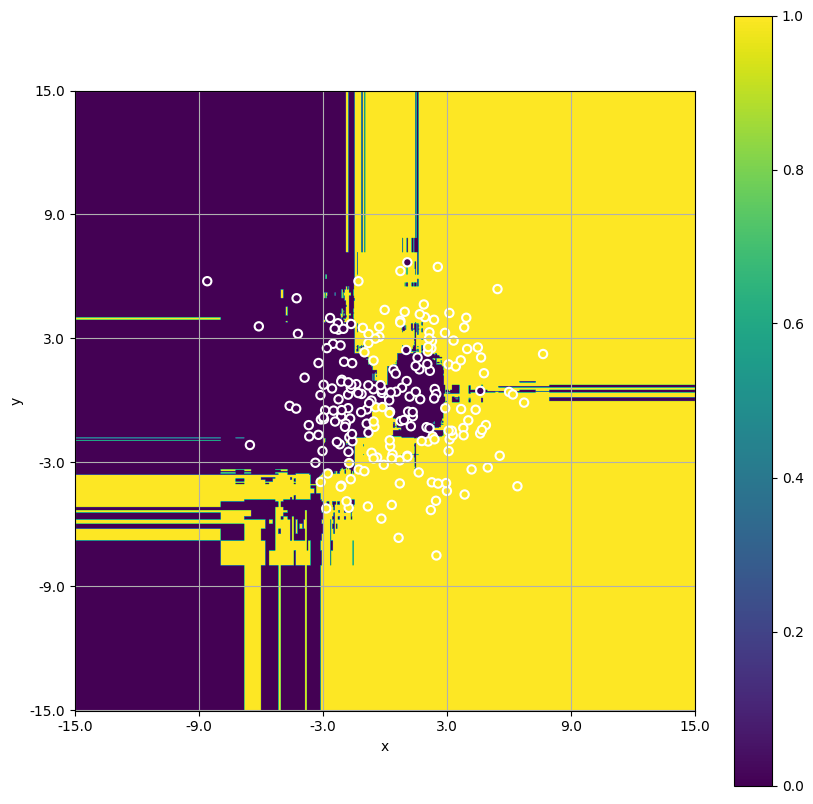

In [ ]:
compare_best_models(CatBoostClassifier,
                    X_train_synthetic,
                    X_test_synthetic,
                    y_train_synthetic,
                    y_test_synthetic,
                    True,
                    **best_catboost_trial.params)

In [117]:
def objective(trial):
    train_pool = Pool(X_train_synthetic, y_train_synthetic)

    test_pool = Pool(X_test_synthetic, y_test_synthetic,)
    boosting_params = {}
    model_params = {}
    boosting_params['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 0.71, step=0.05)
    model_params['max_depth'] = trial.suggest_int('max_depth', 4, 8)
    model_params['min_samples_leaf'] = trial.suggest_categorical('min_samples_leaf', [1, 4, 8, 16, 24])
    boosting_params['subsample'] = trial.suggest_float("subsample", 0.3, 0.7, step=0.1)
    boosting_params['n_estimators'] = 200
    boosting_params['use_best_model'] = True

    model = Boosting(base_model_params=model_params, **boosting_params)
    model.fit(X_train_synthetic, y_train_synthetic, (X_test_synthetic, y_test_synthetic))
    pred = np.round(model.predict(X_test_synthetic) > 0.5)
    accuracy = accuracy_score((y_test_synthetic == 1), np.round(pred))
    return accuracy

In [118]:
best_own_boosting_model = optuna_fit()

[I 2024-02-02 12:54:49,507] A new study created in memory with name: no-name-ef4bc834-2b9f-4b80-a1fb-45a43398db6d


------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4199116875182227
Сейчас обучается модель:  2
current loss =  0.3782269700146065
Сейчас обучается модель:  3
current loss =  0.35475752395440224
Сейчас обучается модель:  4
current loss =  0.3364401115278709
Сейчас обучается модель:  5
current loss =  0.32097100130801426
Сейчас обучается модель:  6
current loss =  0.3087215474443983
Сейчас обучается модель:  7
current loss =  0.2984368239117526
Сейчас обучается модель:  8
current loss =  0.2899917648144747
Сейчас обучается модель:  9
current loss =  0.28289197787028403
Сейчас обучается модель:  10
current loss =  0.2768051531861395
Сейчас обучается модель:  11
current loss =  0.2716356396762117
Сейчас обучается модель:  12
current loss =  0.2658688272291949
Сейчас обучается модель:  13
current loss =  0.26113520421171627
Сейчас обучается модель:  14
current loss =  0.25731338171427576
Сейчас обучается модель:  15
current

[I 2024-02-02 12:56:05,107] Trial 0 finished with value: 0.914 and parameters: {'learning_rate': 0.51, 'max_depth': 4, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 0 with value: 0.914.


Сейчас обучается модель:  199
------------------------------------
------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4197616875182227
Сейчас обучается модель:  2
current loss =  0.3783518270300254
Сейчас обучается модель:  3
current loss =  0.3557167759719533
Сейчас обучается модель:  4
current loss =  0.3377555966771655
Сейчас обучается модель:  5
current loss =  0.3233086552511989
Сейчас обучается модель:  6
current loss =  0.31109647356510406
Сейчас обучается модель:  7
current loss =  0.30123317869283334
Сейчас обучается модель:  8
current loss =  0.29305251961473827
Сейчас обучается модель:  9
current loss =  0.285953744349607
Сейчас обучается модель:  10
current loss =  0.2791630445121476
Сейчас обучается модель:  11
current loss =  0.2738672746644266
Сейчас обучается модель:  12
current loss =  0.2693028646101175
Сейчас обучается модель:  13
current loss =  0.26541963617466263
Сейчас обучается модель:  14
curren

[I 2024-02-02 12:57:18,008] Trial 1 finished with value: 0.9136 and parameters: {'learning_rate': 0.56, 'max_depth': 4, 'min_samples_leaf': 16, 'subsample': 0.4}. Best is trial 0 with value: 0.914.


Сейчас обучается модель:  199
------------------------------------
------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4187116875182227
Сейчас обучается модель:  2
current loss =  0.368214008974923
Сейчас обучается модель:  3
current loss =  0.3294906438425827
Сейчас обучается модель:  4
current loss =  0.29833947458344656
Сейчас обучается модель:  5
current loss =  0.273565728097605
Сейчас обучается модель:  6
current loss =  0.2543727687768628
Сейчас обучается модель:  7
current loss =  0.23948006394481117
Сейчас обучается модель:  8
current loss =  0.22844486866112912
Сейчас обучается модель:  9
current loss =  0.2201595391142464
Сейчас обучается модель:  10
current loss =  0.21406344910738953
Сейчас обучается модель:  11
current loss =  0.21010322433223164
Сейчас обучается модель:  12
current loss =  0.20745150117357034
Сейчас обучается модель:  13
current loss =  0.20628172162286973
Сейчас обучается модель:  14
curr

[I 2024-02-02 12:58:52,385] Trial 2 finished with value: 0.9133 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 8, 'min_samples_leaf': 24, 'subsample': 0.4}. Best is trial 0 with value: 0.914.


Сейчас обучается модель:  199
------------------------------------
------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.41986168751822267
Сейчас обучается модель:  2
current loss =  0.3736725794629724
Сейчас обучается модель:  3
current loss =  0.3505606245850232
Сейчас обучается модель:  4
current loss =  0.33290713831577795
Сейчас обучается модель:  5
current loss =  0.31818861145077587
Сейчас обучается модель:  6
current loss =  0.3061525956036595
Сейчас обучается модель:  7
current loss =  0.29581137917077194
Сейчас обучается модель:  8
current loss =  0.2867813898189723
Сейчас обучается модель:  9
current loss =  0.2791511736157359
Сейчас обучается модель:  10
current loss =  0.2726477159542969
Сейчас обучается модель:  11
current loss =  0.2668858107633053
Сейчас обучается модель:  12
current loss =  0.26120989575849196
Сейчас обучается модель:  13
current loss =  0.25662370860092815
Сейчас обучается модель:  14
cur

[I 2024-02-02 13:00:06,141] Trial 3 finished with value: 0.912 and parameters: {'learning_rate': 0.66, 'max_depth': 5, 'min_samples_leaf': 4, 'subsample': 0.3}. Best is trial 0 with value: 0.914.


------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.41936168751822267
Сейчас обучается модель:  2
current loss =  0.36931827214990043
Сейчас обучается модель:  3
current loss =  0.337699921182715
Сейчас обучается модель:  4
current loss =  0.31281051938350996
Сейчас обучается модель:  5
current loss =  0.2927197298102181
Сейчас обучается модель:  6
current loss =  0.27614319705903706
Сейчас обучается модель:  7
current loss =  0.26280648102905374
Сейчас обучается модель:  8
current loss =  0.252008707341647
Сейчас обучается модель:  9
current loss =  0.2432733662147748
Сейчас обучается модель:  10
current loss =  0.2360177212794493
Сейчас обучается модель:  11
current loss =  0.2300123622665113
Сейчас обучается модель:  12
current loss =  0.22490692257730793
Сейчас обучается модель:  13
current loss =  0.22079639622550448
Сейчас обучается модель:  14
current loss =  0.21743866313980567
Сейчас обучается модель:  15
curren

[I 2024-02-02 13:01:43,609] Trial 4 finished with value: 0.91265 and parameters: {'learning_rate': 0.36000000000000004, 'max_depth': 8, 'min_samples_leaf': 4, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 0.914.


Сейчас обучается модель:  199
------------------------------------
------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4188116875182227
Сейчас обучается модель:  2
current loss =  0.371113021462116
Сейчас обучается модель:  3
current loss =  0.3336502968781475
Сейчас обучается модель:  4
current loss =  0.30377729424821664
Сейчас обучается модель:  5
current loss =  0.27975474048102006
Сейчас обучается модель:  6
current loss =  0.2608301288757547
Сейчас обучается модель:  7
current loss =  0.24681048105275918
Сейчас обучается модель:  8
current loss =  0.23567466892861524
Сейчас обучается модель:  9
current loss =  0.22761333614569848
Сейчас обучается модель:  10
current loss =  0.2217809202238044
Сейчас обучается модель:  11
current loss =  0.21817154367806488
Сейчас обучается модель:  12
current loss =  0.2155687514479032
Сейчас обучается модель:  13
current loss =  0.21449983633372877
Сейчас обучается модель:  14
cur

[I 2024-02-02 13:03:04,612] Trial 5 finished with value: 0.91235 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 6, 'min_samples_leaf': 16, 'subsample': 0.3}. Best is trial 0 with value: 0.914.


Сейчас обучается модель:  199
------------------------------------
------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4189116875182227
Сейчас обучается модель:  2
current loss =  0.3774331803631678
Сейчас обучается модель:  3
current loss =  0.3510103670961874
Сейчас обучается модель:  4
current loss =  0.3302042409358476
Сейчас обучается модель:  5
current loss =  0.3137953016595203
Сейчас обучается модель:  6
current loss =  0.30041509396654975
Сейчас обучается модель:  7
current loss =  0.2897713020738945
Сейчас обучается модель:  8
current loss =  0.2812266032947368
Сейчас обучается модель:  9
current loss =  0.274063825232414
Сейчас обучается модель:  10
current loss =  0.2685448704902481
Сейчас обучается модель:  11
current loss =  0.2637775920473121
Сейчас обучается модель:  12
current loss =  0.25977980450135996
Сейчас обучается модель:  13
current loss =  0.2567150785705324
Сейчас обучается модель:  14
current 

[I 2024-02-02 13:04:16,352] Trial 6 finished with value: 0.9188 and parameters: {'learning_rate': 0.36000000000000004, 'max_depth': 4, 'min_samples_leaf': 4, 'subsample': 0.3}. Best is trial 6 with value: 0.9188.


Сейчас обучается модель:  199
------------------------------------
------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4204116875182227
Сейчас обучается модель:  2
current loss =  0.3785726519364946
Сейчас обучается модель:  3
current loss =  0.3507560483922483
Сейчас обучается модель:  4
current loss =  0.3287248021365602
Сейчас обучается модель:  5
current loss =  0.3111335027145667
Сейчас обучается модель:  6
current loss =  0.2973483443053651
Сейчас обучается модель:  7
current loss =  0.2865217307976444
Сейчас обучается модель:  8
current loss =  0.2780380123024505
Сейчас обучается модель:  9
current loss =  0.2713570524994883
Сейчас обучается модель:  10
current loss =  0.26564021055363274
Сейчас обучается модель:  11
current loss =  0.2613529000081967
Сейчас обучается модель:  12
current loss =  0.2578322137077056
Сейчас обучается модель:  13
current loss =  0.2556742297822574
Сейчас обучается модель:  14
current 

[I 2024-02-02 13:05:35,399] Trial 7 finished with value: 0.9182 and parameters: {'learning_rate': 0.31000000000000005, 'max_depth': 4, 'min_samples_leaf': 1, 'subsample': 0.6000000000000001}. Best is trial 6 with value: 0.9188.


Сейчас обучается модель:  199
------------------------------------
Number of finished trials: 8
Best trial:
  Value: 0.9188
  Params: 
    learning_rate: 0.36000000000000004
    max_depth: 4
    min_samples_leaf: 4
    subsample: 0.3


------------------------------------
current loss =  0.6931471805599453
Сейчас обучается модель:  1
current loss =  0.4193116875182227
Сейчас обучается модель:  2
current loss =  0.3775693246312918
Сейчас обучается модель:  3
current loss =  0.35129040877503953
Сейчас обучается модель:  4
current loss =  0.3304978850204508
Сейчас обучается модель:  5
current loss =  0.3132745028984137
Сейчас обучается модель:  6
current loss =  0.3000339526714035
Сейчас обучается модель:  7
current loss =  0.2891641646618021
Сейчас обучается модель:  8
current loss =  0.2802611196528695
Сейчас обучается модель:  9
current loss =  0.27319599558608254
Сейчас обучается модель:  10
current loss =  0.267679178372374
Сейчас обучается модель:  11
current loss =  0.2634592833820446
Сейчас обучается модель:  12
current loss =  0.25955906345424334
Сейчас обучается модель:  13
current loss =  0.2563142340801925
Сейчас обучается модель:  14
current loss =  0.2524878257590349
Сейчас обучается модель:  15
current lo

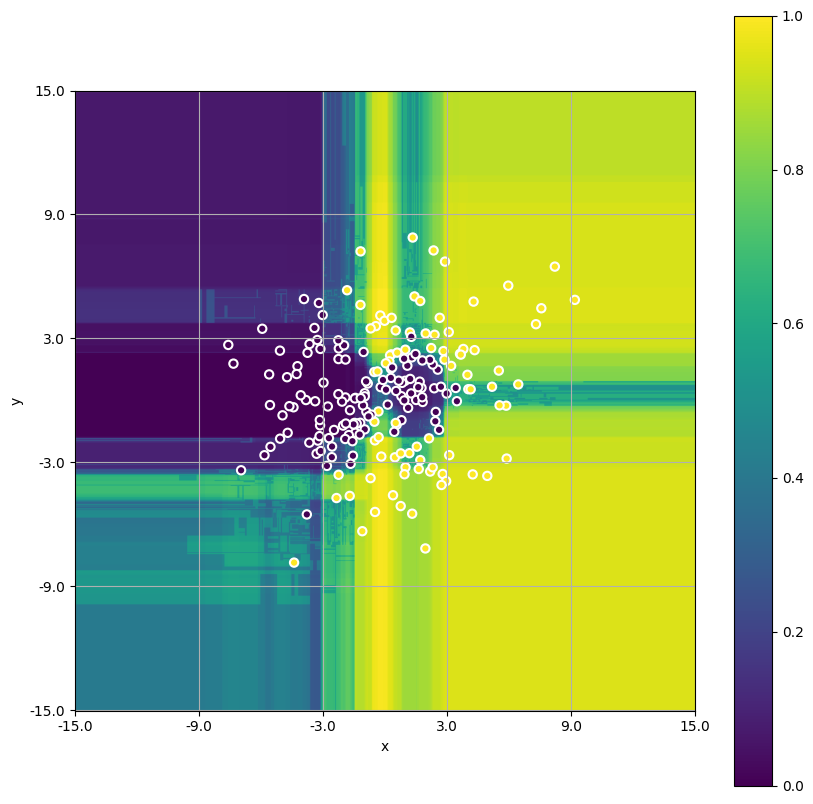

In [124]:
boosting_params = {}
model_params = {}
boosting_params['learning_rate'] = 0.36000000000000004
model_params['max_depth'] = 4
model_params['min_samples_leaf'] = 4
boosting_params['subsample'] = 0.3
boosting_params['n_estimators'] = 200
boosting_params['use_best_model'] = True

variable_models(base_estimator=DecisionTreeRegressor,
                base_params=model_params,
                X_train=X_train_synthetic,
                X_test=X_test_synthetic,
                y_train=y_train_synthetic,
                y_test=y_test_synthetic,
                eval_set=(X_test_synthetic, y_test_synthetic),
                synthetic=True,
                **boosting_params)

***Выводы***: \
Моя реализация немного хуже, чем catboost на тестовых данных \
0.91985 на моей реализации против 0.9225 на catboost \
Разница совсем незначительная